In [5]:
pip install statsmodels

     ---------------------------------------- 9.2/9.2 MB 3.3 MB/s eta 0:00:00
     -------------------------------------- 233.8/233.8 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA, KernelPCA
import random
import warnings
warnings.filterwarnings("ignore")

### Tool function

In [7]:
def get_top_value(data_in, ratio):
    data = data_in.copy()
    index=data.argsort()
    return data[index.iloc[-int(data.shape[0]*ratio)]]

### data preprocessing

#### read data

In [8]:
data = pd.read_csv("../data/OnlineNewsPopularity.csv", index_col=False)
data.columns = [c.strip() for c in data.columns]
all_attribute_names = list(data.columns)
all_attribute_names.remove("shares")
all_attribute_names.remove("url")
label_names = ["shares"]
print(f"Total number of samples:{data.shape[0]}, attributes number:{len(all_attribute_names)}")
print(f"min shares = {np.min(data['shares'])}, max shares = {np.max(data['shares'])}")

Total number of samples:39644, attributes number:59
min shares = 1, max shares = 843300


#### label(shares number) processing

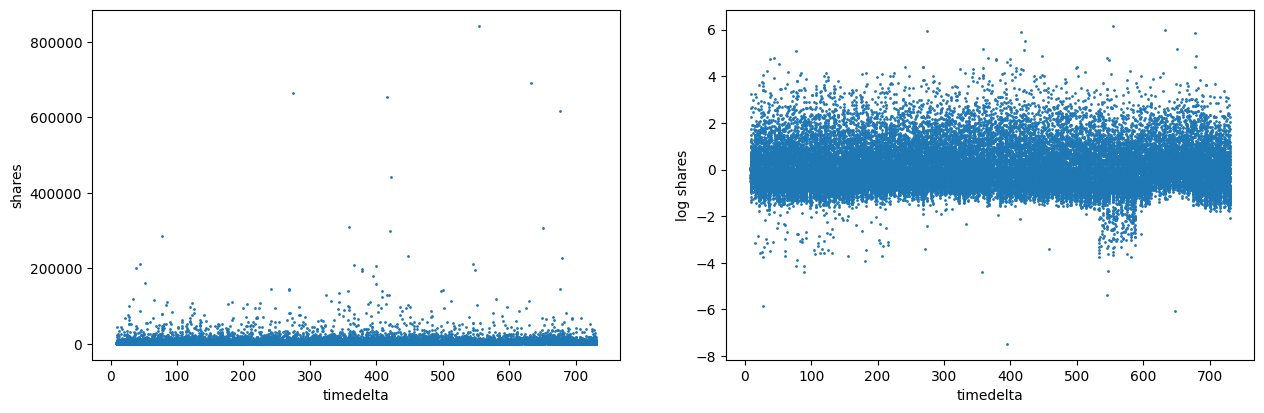

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(data[all_attribute_names[0]], data[label_names], s=1)
plt.xlabel(f'{all_attribute_names[0]}')
plt.ylabel('shares')
plt.subplot(2, 2, 2)
log_shares_and_centered = np.log(data[label_names]) - np.mean(np.log(data[label_names]))
plt.scatter(data[all_attribute_names[0]], log_shares_and_centered, s=1)
plt.xlabel(f'{all_attribute_names[0]}')
plt.ylabel('log shares')
plt.show()

# log processing
data["shares"] = log_shares_and_centered

#### extreme value processing

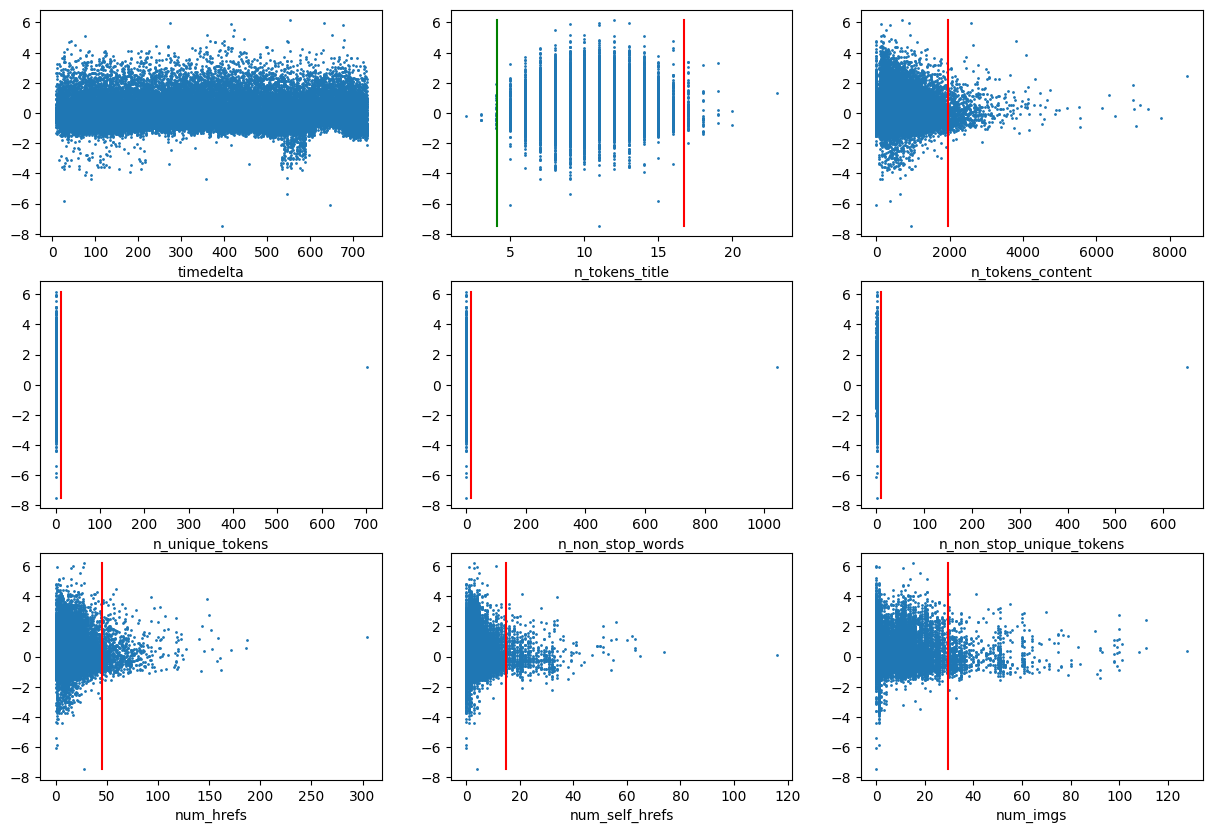

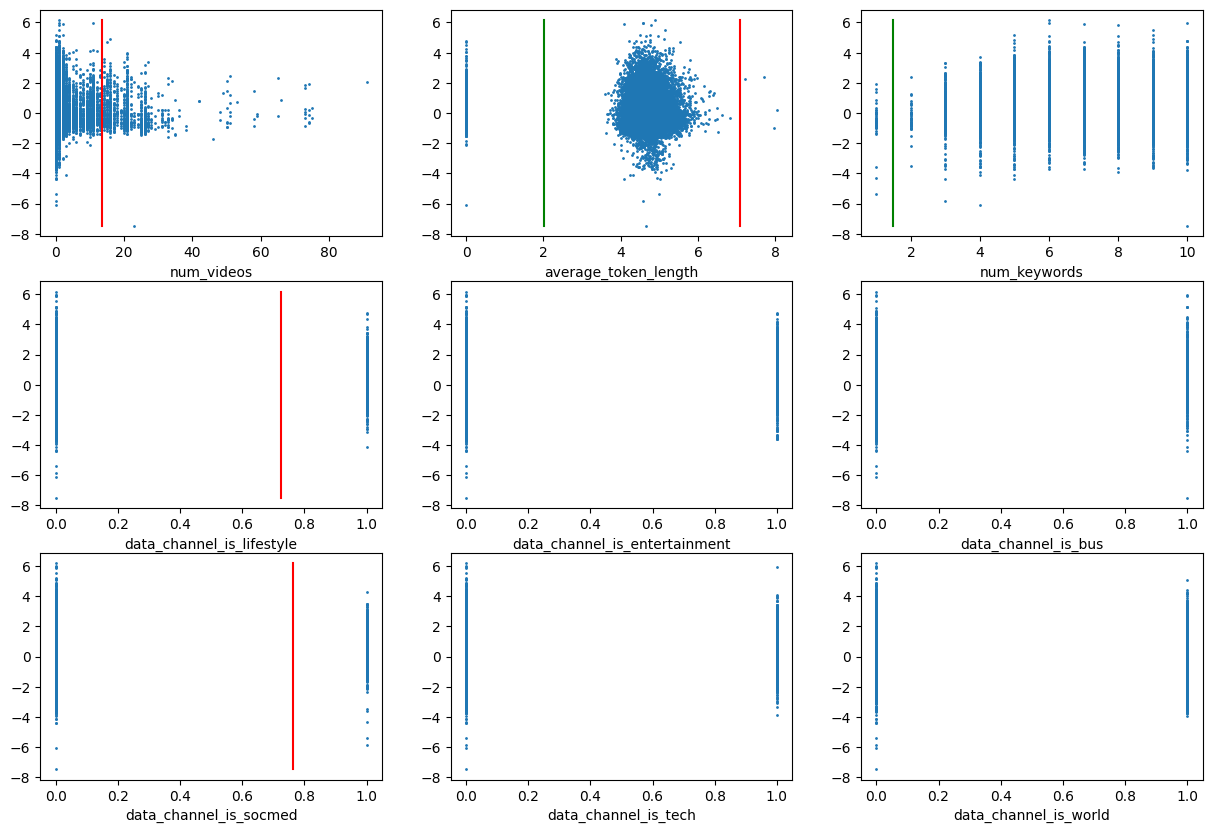

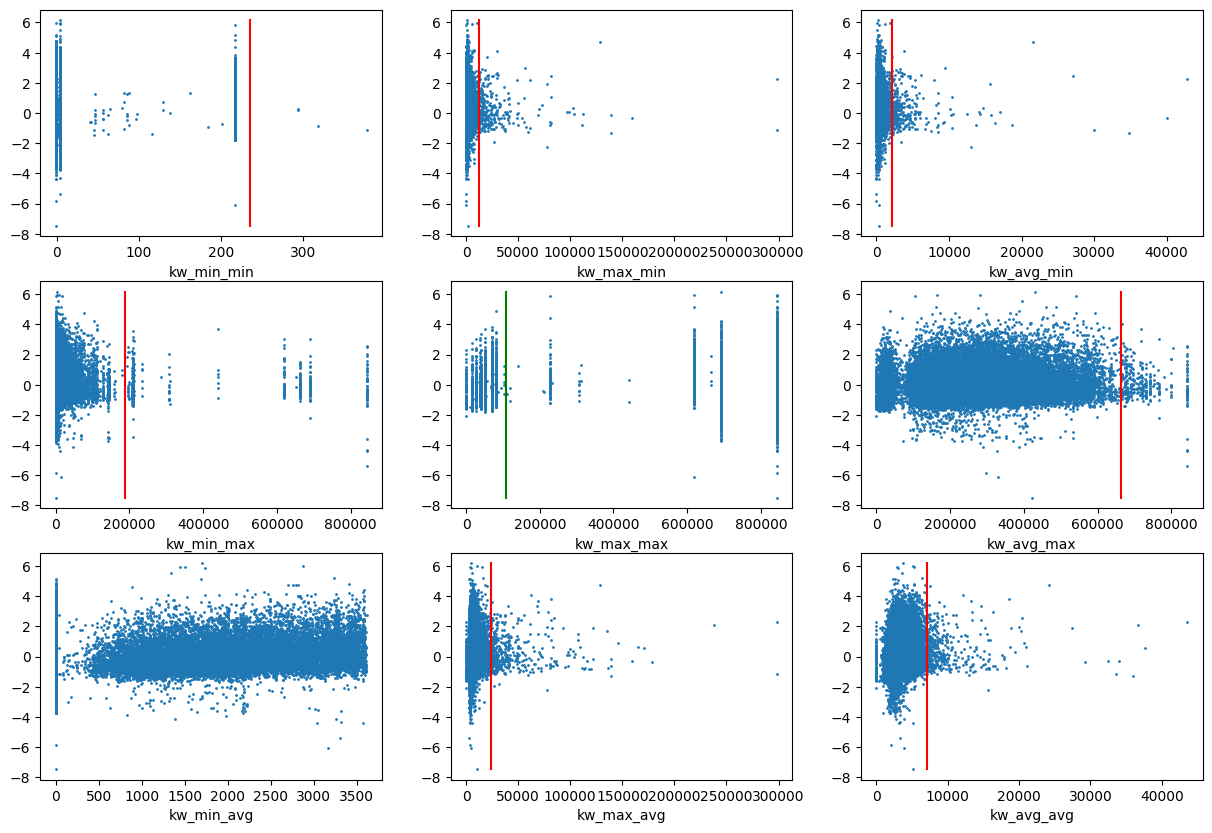

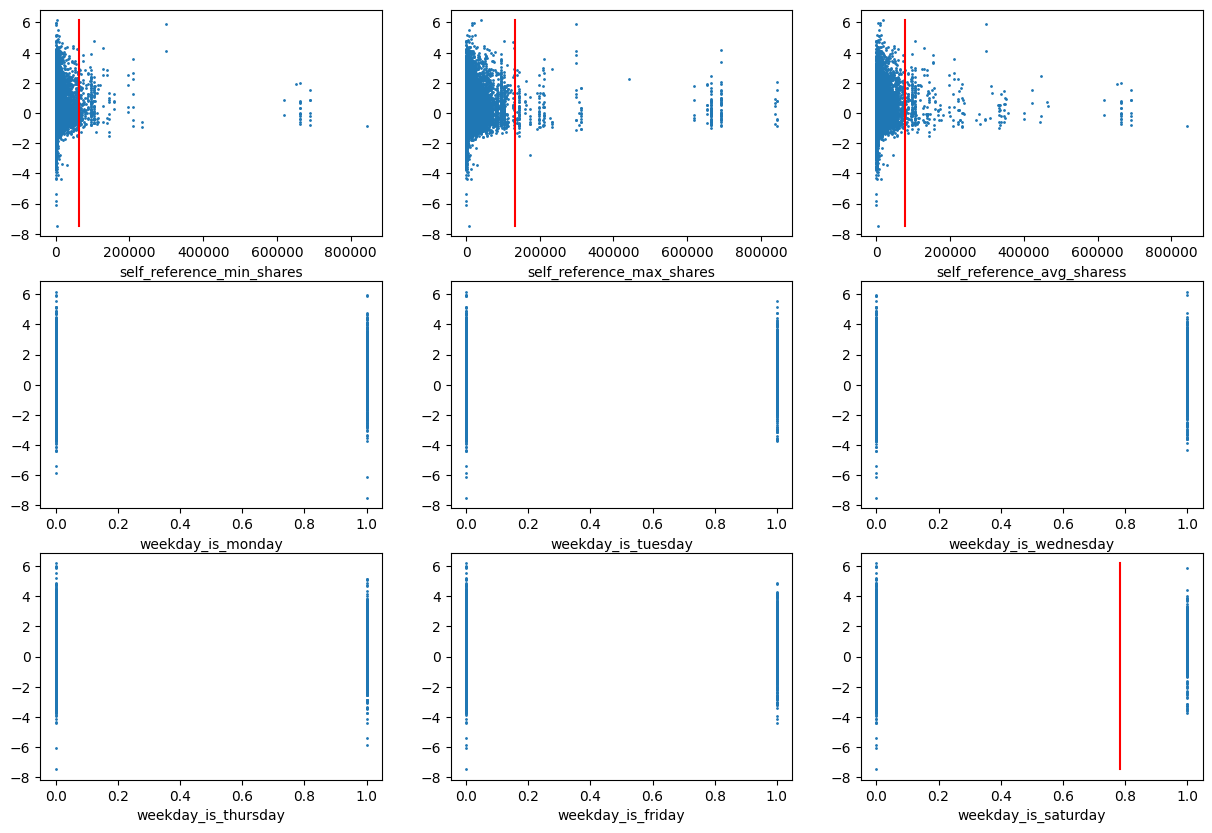

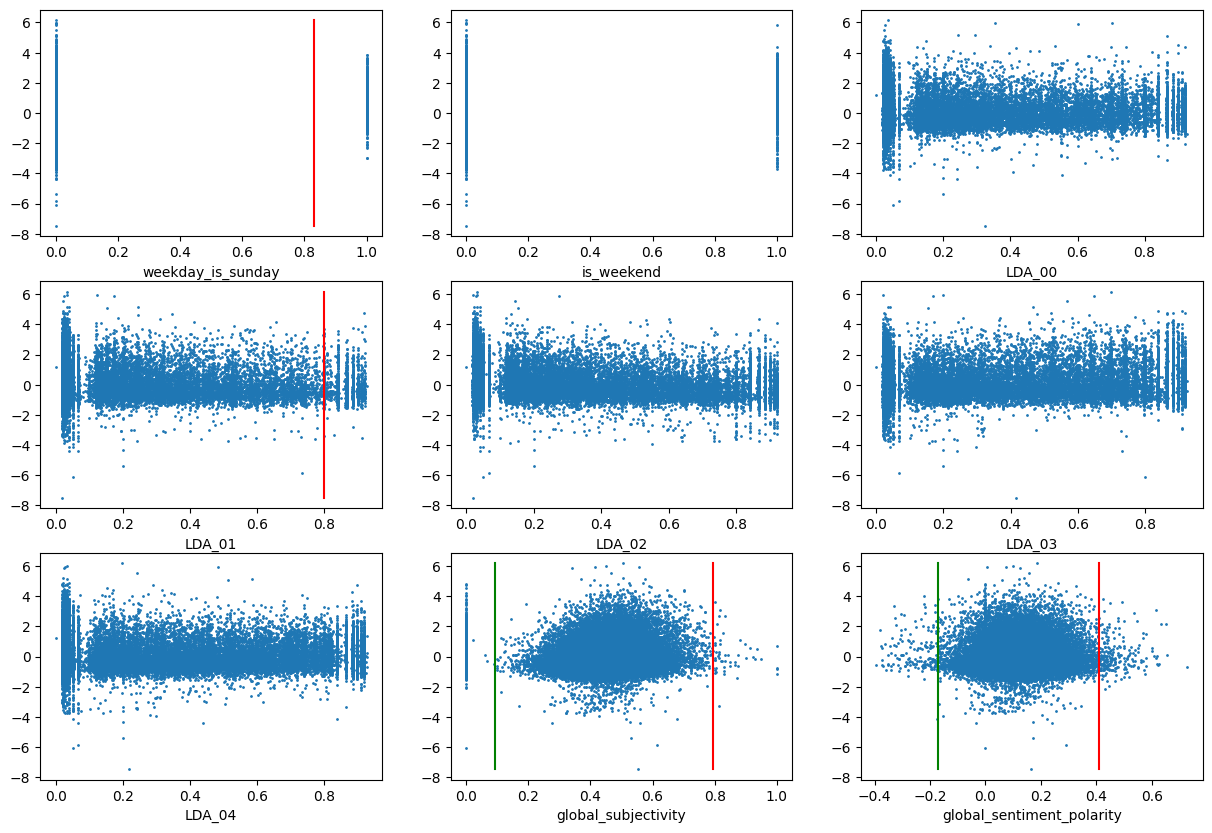

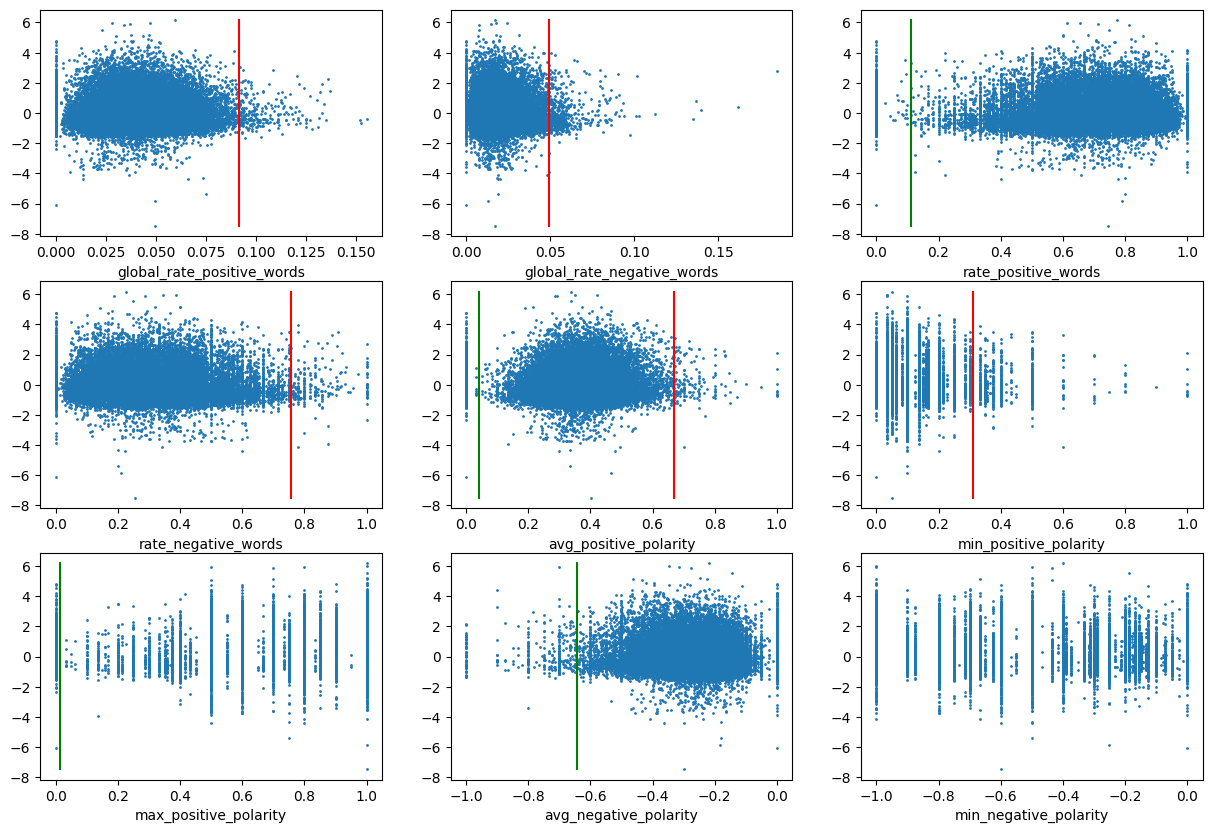

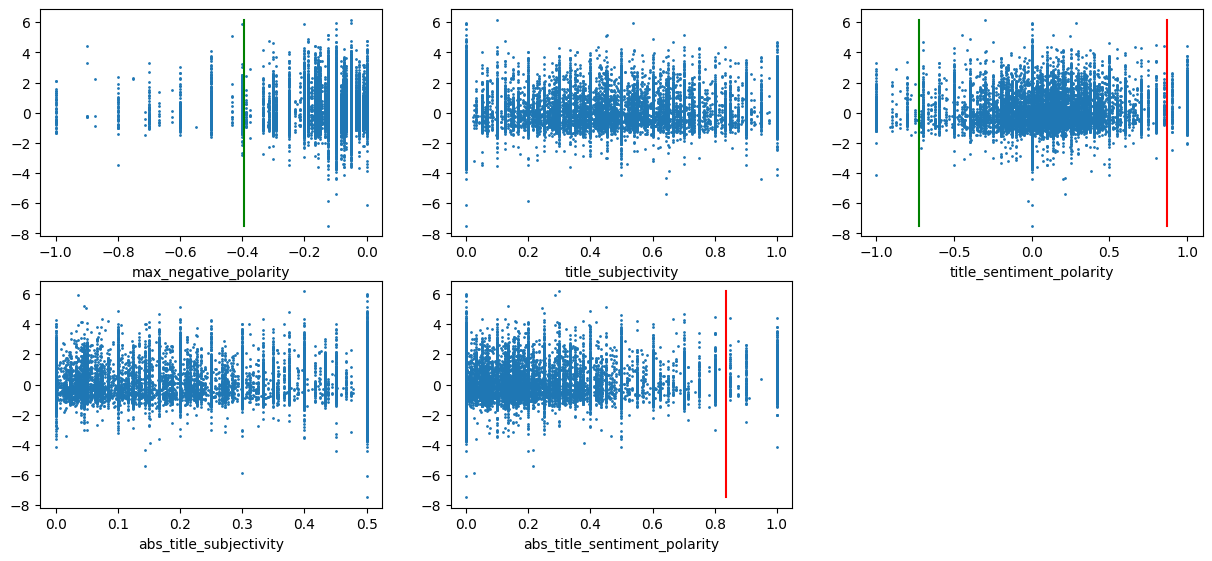

In [10]:
X = data[all_attribute_names].copy().values
for i, attribute_name in enumerate(all_attribute_names):
    if i % 9 == 0:
        plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, i%9+1)

    hight_threshold = np.mean(X[:, i]) + 3 * np.std(X[:, i])
    low_threshold = np.mean(X[:, i]) - 3 * np.std(X[:, i])
    plt.scatter(X[:, i], data["shares"], s=1)
    if low_threshold >= np.min(X[:, i]):
        plt.plot([low_threshold, low_threshold], [np.min(data["shares"]), np.max(data["shares"])], c="green")
    if hight_threshold <= np.max(X[:, i]):
        plt.plot([hight_threshold, hight_threshold], [np.min(data["shares"]), np.max(data["shares"])], c="red")

    plt.xlabel(f'{attribute_name}')
    if i % 9 == 8:
        plt.show()
plt.show()

#### clip extreme values

In [11]:
data["n_tokens_title"] = data["n_tokens_title"].clip(4, 20)
data["n_tokens_content"] = data["n_tokens_content"].clip(0, 4000)
data["n_unique_tokens"] = data["n_unique_tokens"].clip(0, 1)
data["n_non_stop_words"] = data["n_non_stop_words"].clip(0, 1)
data["n_non_stop_unique_tokens"] = data["n_non_stop_unique_tokens"].clip(0, 1)
data["num_hrefs"] = data["num_hrefs"].clip(0, get_top_value(data["num_hrefs"], 0.005))
data["num_self_hrefs"] = data["num_self_hrefs"].clip(0, get_top_value(data["num_self_hrefs"], 0.005))
data["num_imgs"] = data["num_imgs"].clip(0, get_top_value(data["num_imgs"], 0.005))
data["num_videos"] = data["num_videos"].clip(0, get_top_value(data["num_videos"], 0.005))
data["average_token_length"] = data["average_token_length"].clip(0, get_top_value(data["average_token_length"], 0.0005))
data["kw_min_min"] = data["kw_min_min"].clip(0, get_top_value(data["kw_min_min"], 0.005))
data["kw_max_min"] = data["kw_max_min"].clip(0, get_top_value(data["kw_max_min"], 0.005))
data["kw_avg_min"] = data["kw_avg_min"].clip(0, get_top_value(data["kw_avg_min"], 0.005))
data["kw_max_avg"] = data["kw_max_avg"].clip(0, get_top_value(data["kw_max_avg"], 0.005))
data["kw_avg_avg"] = data["kw_avg_avg"].clip(0, get_top_value(data["kw_avg_avg"], 0.005))
data["self_reference_min_shares"] = data["self_reference_min_shares"].clip(0, get_top_value(data["self_reference_min_shares"], 0.005))
data["self_reference_max_shares"] = data["self_reference_max_shares"].clip(0, get_top_value(data["self_reference_max_shares"], 0.005))
data["self_reference_avg_sharess"] = data["self_reference_avg_sharess"].clip(0, get_top_value(data["self_reference_avg_sharess"], 0.005))
data["global_rate_positive_words"] = data["global_rate_positive_words"].clip(0, get_top_value(data["global_rate_positive_words"], 0.0005))
data["global_rate_negative_words"] = data["global_rate_negative_words"].clip(0, get_top_value(data["global_rate_negative_words"], 0.0005))

#### combining features

 The combination of channel and some statistical attributes, taking into account that people of different channels have different preferences for the number of words, pictures, and videos

In [12]:
all_construct_attribute_names = []
for channel in ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]:
    for f in ["n_tokens_title", "n_tokens_content", "n_unique_tokens", "n_non_stop_words", "n_non_stop_unique_tokens", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos", "average_token_length", "num_keywords"]:
        channel_name = channel.split("_")[-1]
        all_construct_attribute_names.append(f"{channel_name}_{f}")
        data[f"{channel_name}_{f}"] = data[channel] * data[f]

The combination of channel and week X, considering that people of different channels may read articles at different times

In [26]:
for channel in ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]:
    for f in ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday", "is_weekend"]:
        channel_name = channel.split("_")[-1]
        all_construct_attribute_names.append(f"{channel_name}_{f}")
        data[f"{channel_name}_{f}"] = data[channel] * data[f]

The combination of channel and LDA topics, considering that different channel people like different LDA topics

In [27]:
for channel in ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]:
    for f in ["LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04"]:
        channel_name = channel.split("_")[-1]
        all_construct_attribute_names.append(f"{channel_name}_{f}")
        data[f"{channel_name}_{f}"] = data[channel] * data[f]

The combination of channel and article emotion-related attributes, considering that people of different channels like articles with different emotional preferences

In [28]:
for channel in ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]:
    for f in ["global_subjectivity", "global_sentiment_polarity", "global_rate_positive_words", "global_rate_negative_words", "rate_positive_words", "rate_negative_words"]:
        channel_name = channel.split("_")[-1]
        all_construct_attribute_names.append(f"{channel_name}_{f}")
        data[f"{channel_name}_{f}"] = data[channel] * data[f]

The combination of week and article emotion-related attributes, people may have different weeks every day of the week, and may like articles with different emotional preferences

In [29]:
for weekday in ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday", "is_weekend"]:
    for f in ["global_subjectivity", "global_sentiment_polarity", "global_rate_positive_words", "global_rate_negative_words", "rate_positive_words", "rate_negative_words"]:
        weekday_name = weekday.split("_")[-1]
        all_construct_attribute_names.append(f"{weekday_name}_{f}")
        data[f"{weekday_name}_{f}"] = data[weekday] * data[f]

week and LDA topics

In [30]:
for weekday in ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday", "is_weekend"]:
    for f in ["LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04"]:
        weekday_name = weekday.split("_")[-1]
        all_construct_attribute_names.append(f"{weekday_name}_{f}")
        data[f"{weekday_name}_{f}"] = data[weekday] * data[f]

In [31]:
print(f"The original features have {len(all_attribute_names)}，The new features are {len(all_construct_attribute_names)}")

The original features have 59，The new features are 802


#### Standard

In [32]:
data[all_attribute_names+all_construct_attribute_names] = StandardScaler().fit_transform(data[all_attribute_names+all_construct_attribute_names])

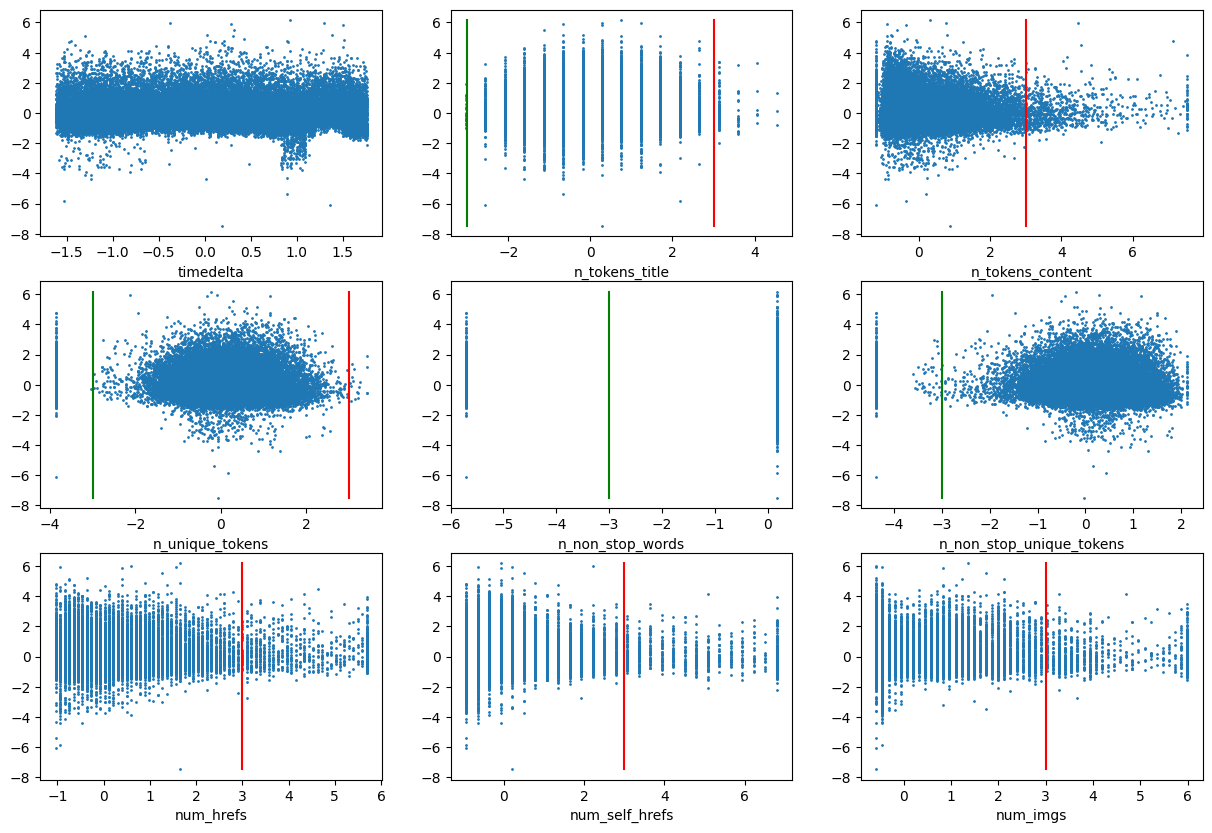

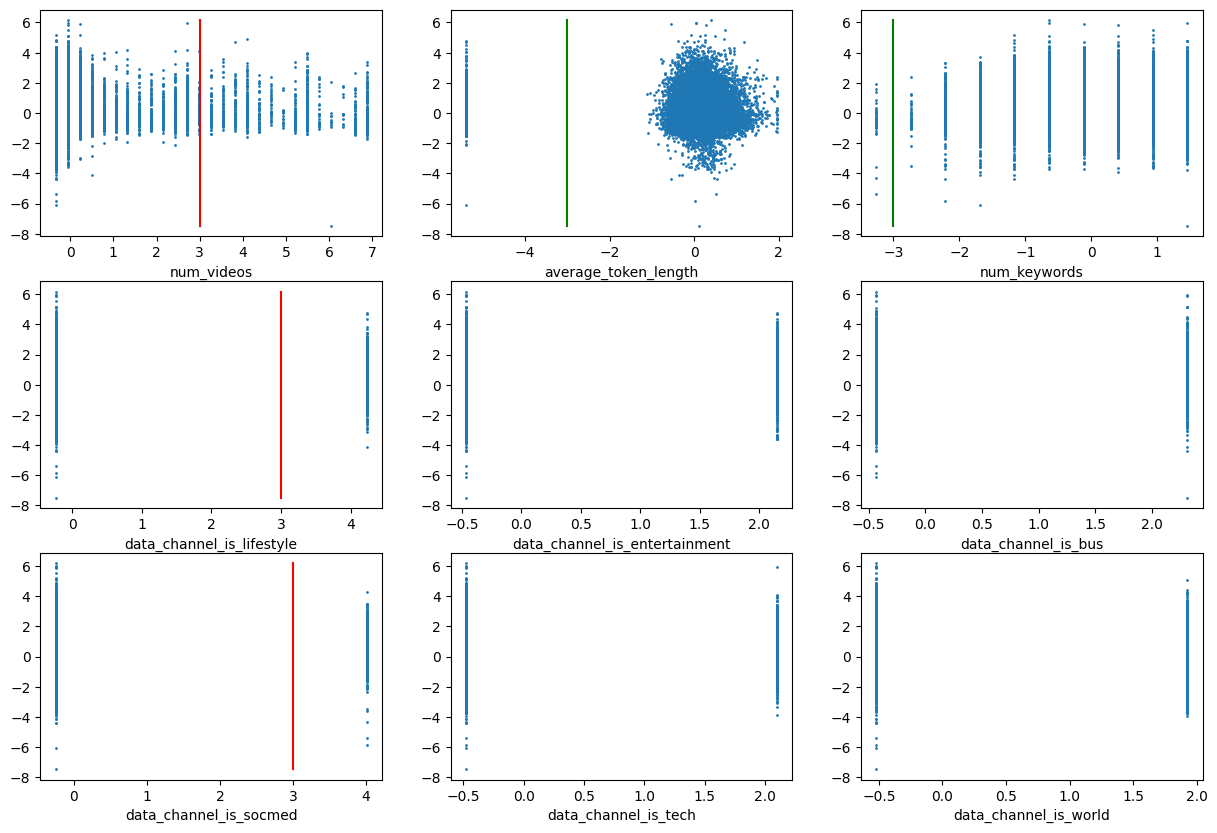

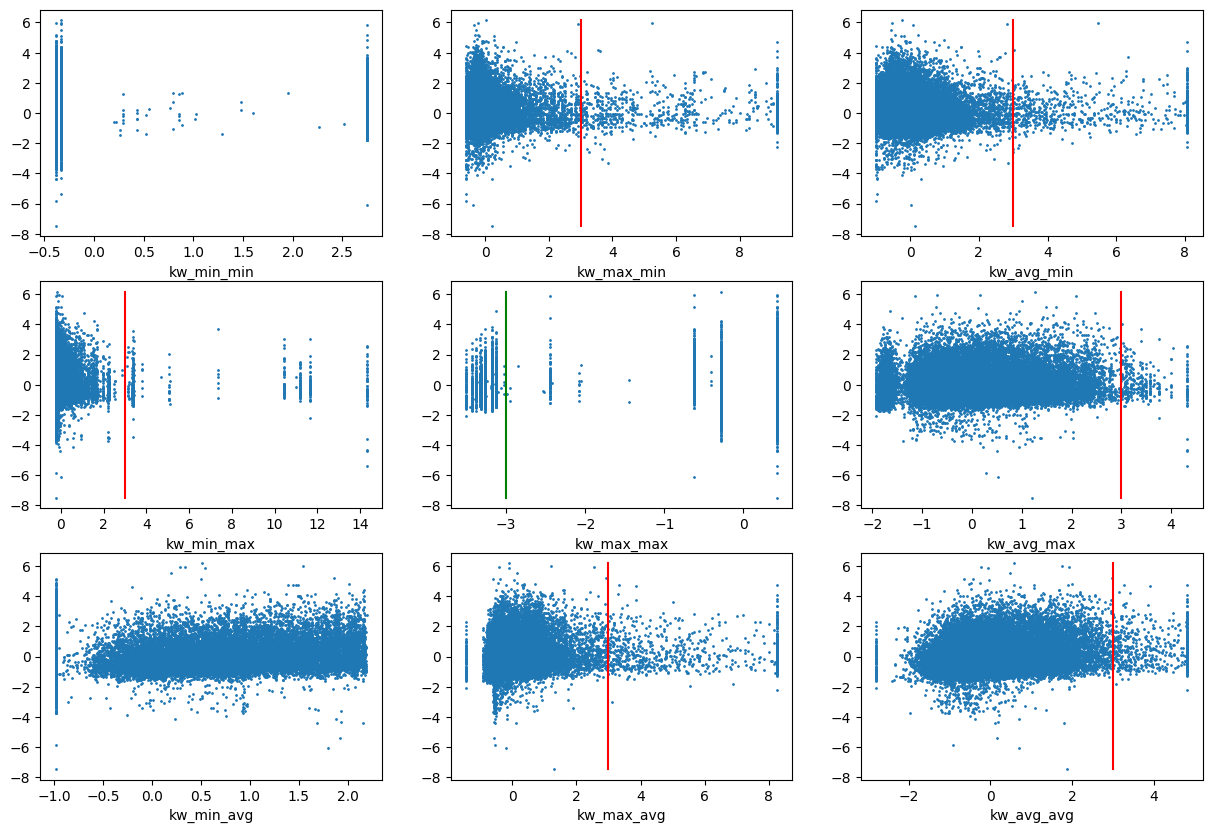

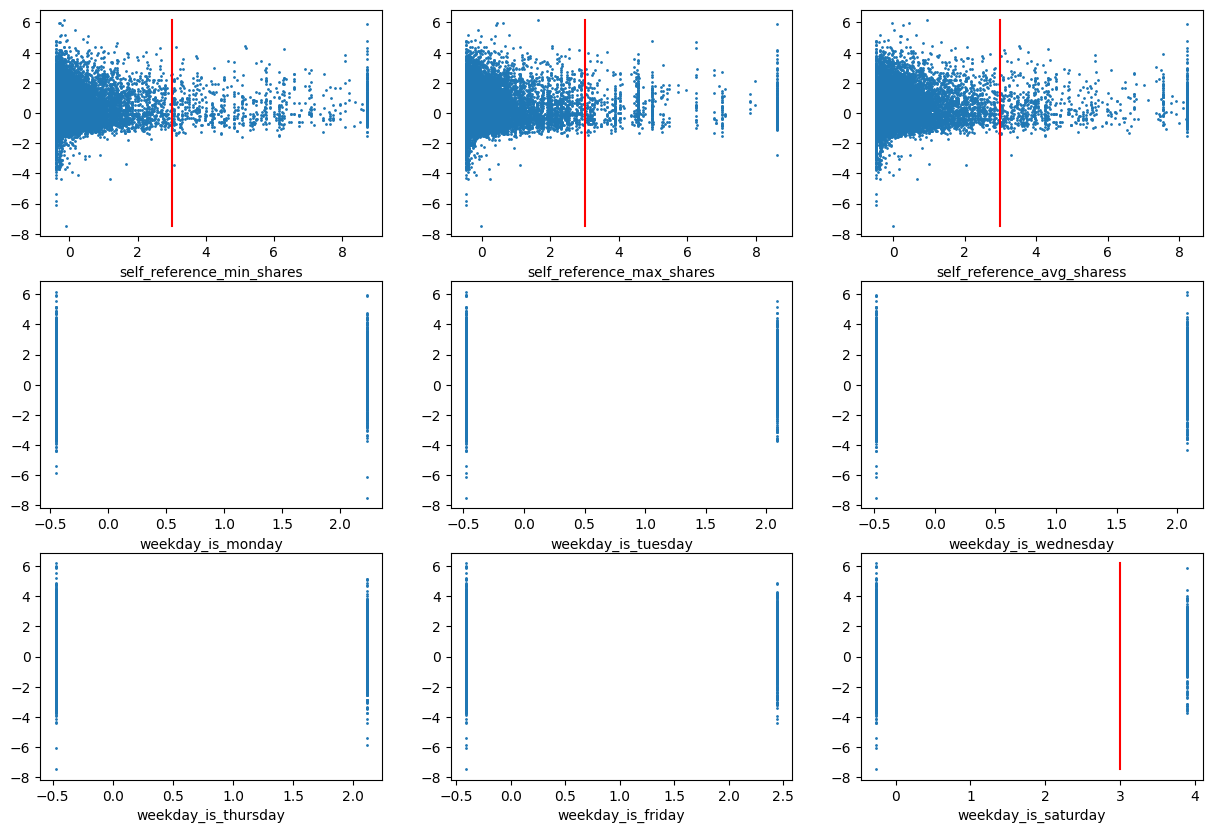

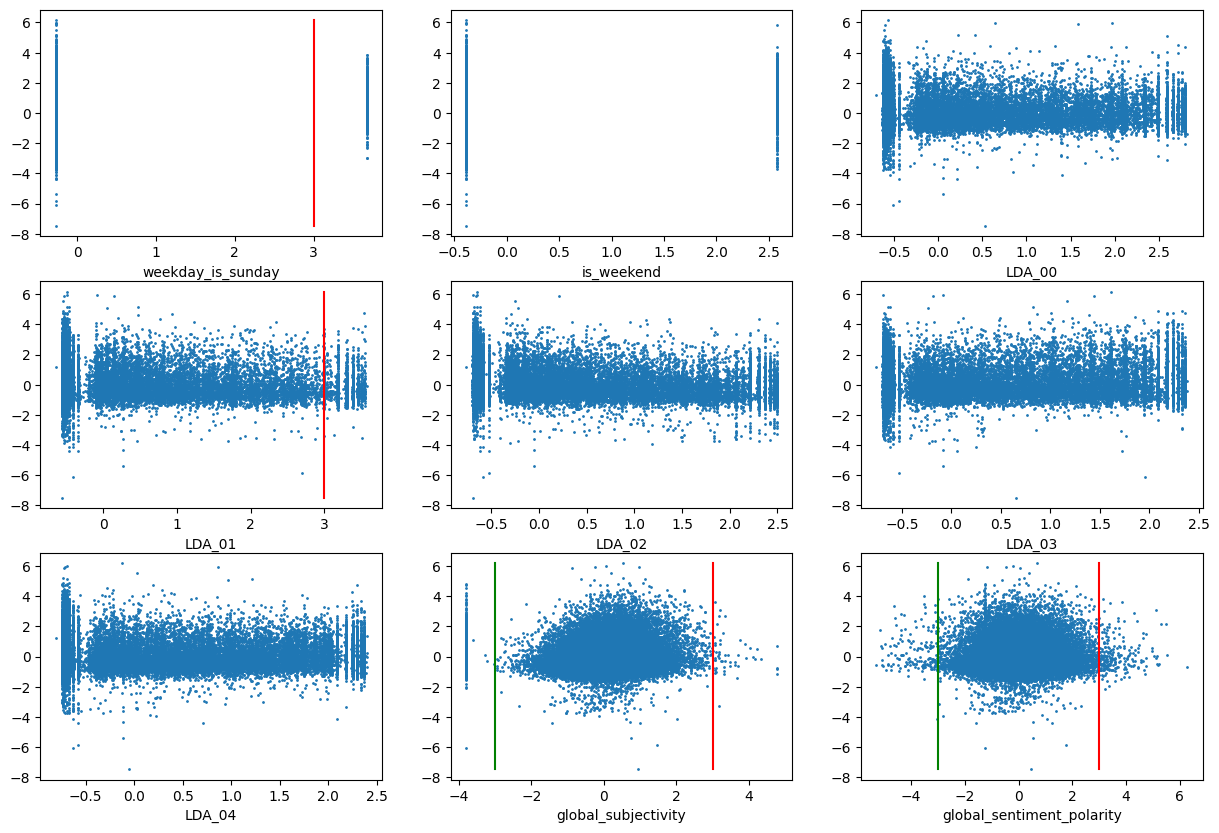

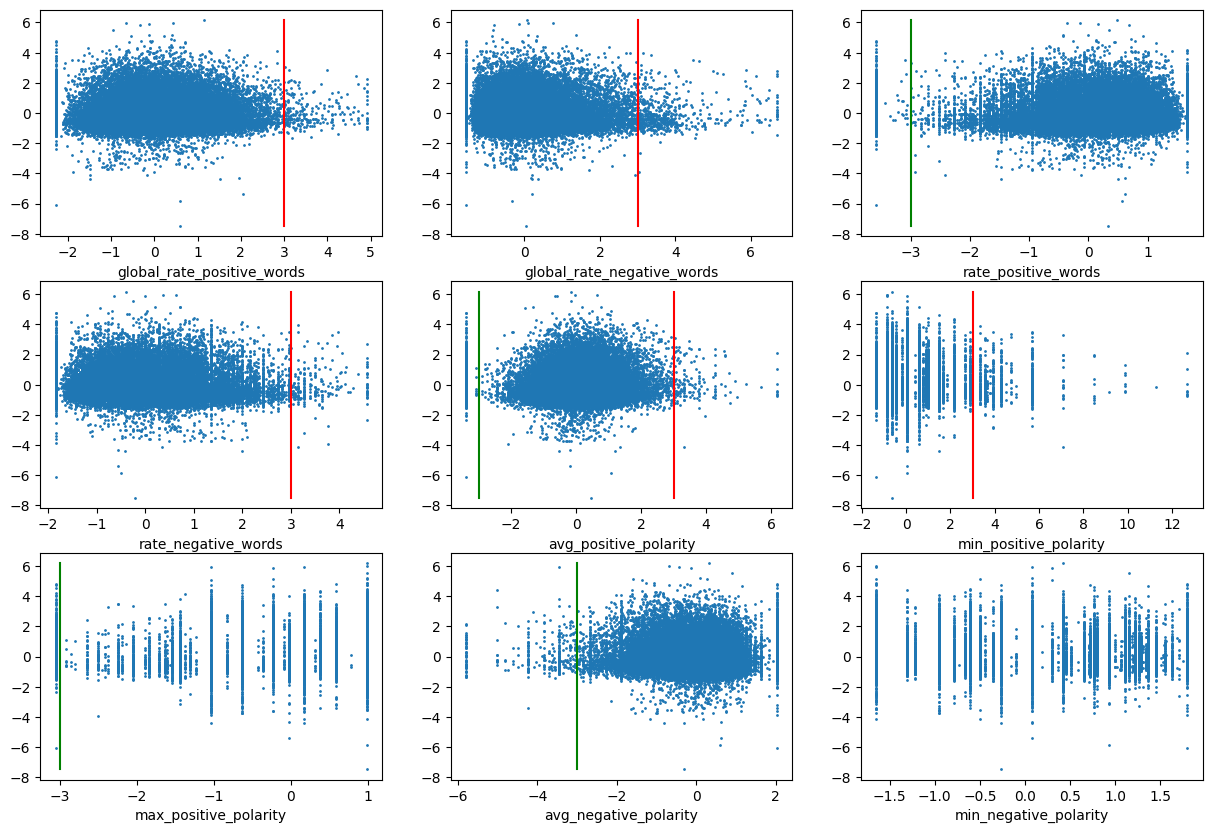

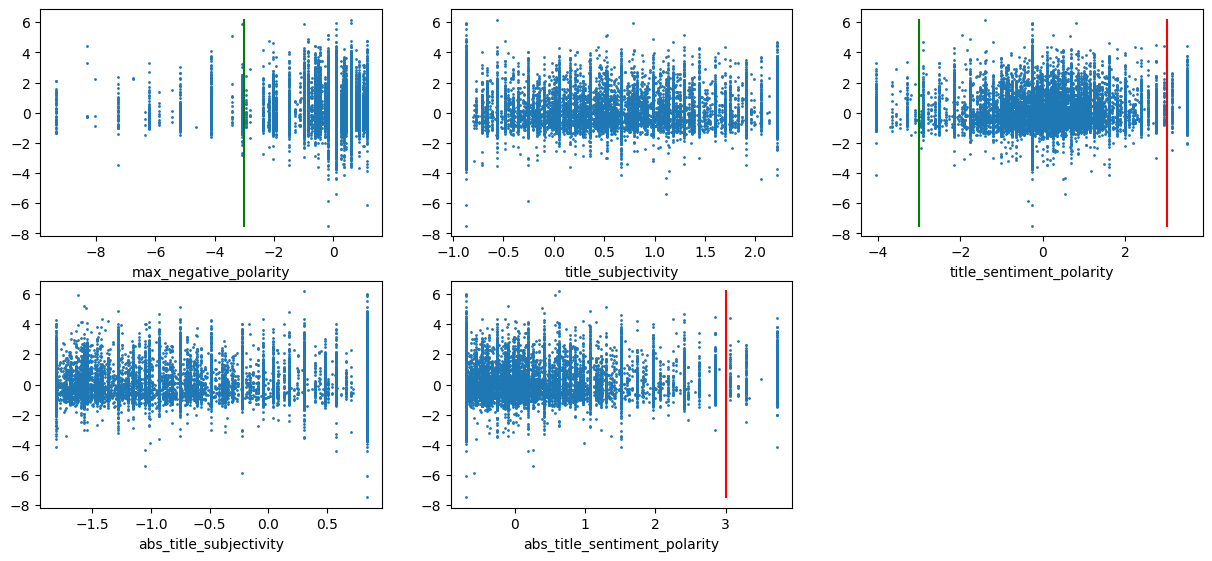

In [33]:
X = data[all_attribute_names].copy().values
for i, attribute_name in enumerate(all_attribute_names):
    if i % 9 == 0:
        plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, i%9+1)

    hight_threshold = np.mean(X[:, i]) + 3 * np.std(X[:, i])
    low_threshold = np.mean(X[:, i]) - 3 * np.std(X[:, i])
    plt.scatter(X[:, i], data["shares"], s=1)
    if low_threshold >= np.min(X[:, i]):
        plt.plot([low_threshold, low_threshold], [np.min(data["shares"]), np.max(data["shares"])], c="green")
    if hight_threshold <= np.max(X[:, i]):
        plt.plot([hight_threshold, hight_threshold], [np.min(data["shares"]), np.max(data["shares"])], c="red")

    plt.xlabel(f'{attribute_name}')
    if i % 9 == 8:
        plt.show()
plt.show()

#### Verifying the effect of new features

In [34]:
X = data[all_attribute_names].copy()
Y = data["shares"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)

model = LinearRegression()
model.fit(X_train, Y_train)
pred = model.predict(X_test)
mse = mean_squared_error(Y_test, pred)
mae = mean_absolute_error(Y_test, pred)
print(f"Before adding new features: mse={mse}, mae={mae}")

Before adding new features: mse=0.7440885265738361, mae=0.6338779055154172


In [35]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)

model = LinearRegression()
model.fit(X_train, Y_train)
pred = model.predict(X_test)
mse = mean_squared_error(Y_test, pred)
mae = mean_absolute_error(Y_test, pred)
print(f"After adding new features, mse={mse}, mae={mae}")

After adding new features, mse=0.7383269333812287, mae=0.6303060866726694


### Model comparison

data

In [36]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()

Trivial

In [37]:
pred = np.mean(Y)
pred = [pred] * Y.shape[0]
trivial_mse = mean_squared_error(Y, pred)
trivial_mae = mean_absolute_error(Y, pred)
print(f"Trivial model, mse={trivial_mse}, mae={trivial_mae}")

Trivial model, mse=0.8657825230332061, mae=0.7043105860922932


LinearRegression

In [38]:
param_grid = [
    {"fit_intercept": [True, False]}
]
model = LinearRegression()
grid_search_lr = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X, Y)

print(f"LinearRegression best parameter:{grid_search_lr.best_params_}, best mse={-grid_search_lr.best_score_}")

LinearRegression best parameter:{'fit_intercept': False}, best mse=1458263933.693336


Lasso

In [60]:
param_grid = [
    {'alpha': [0.0001, 0.001, 0.01, 0.1], "fit_intercept": [True, False]}
]
model = Lasso()
grid_search_lasso = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X, Y)

print(f"Lasso best parameter:{grid_search_lasso.best_params_}, best mse={-grid_search_lasso.best_score_}")

Lasso best parameter:{'alpha': 0.001, 'fit_intercept': False}, best mse=0.7584811101109381


Ridge

In [61]:
param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000, 100000],"fit_intercept": [True, False]}
]
model = Ridge()
grid_search_ridge = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X, Y)

print(f"Ridge best parameter:{grid_search_ridge.best_params_}, best mse={-grid_search_ridge.best_score_}")

Ridge best parameter:{'alpha': 1000, 'fit_intercept': False}, best mse=0.7547292276557795


DecisionTreeRegressor

In [62]:
param_grid = [
    {'min_samples_leaf': [250, 300, 350, 400, 450, 500], "criterion":["friedman_mse", "squared_error"]}
]
model = DecisionTreeRegressor()
grid_search_tree = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_tree.fit(X, Y)

print(f"DecisionTreeRegressor best parameter:{grid_search_tree.best_params_}, best mse={-grid_search_tree.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......criterion=friedman_mse, min_samples_leaf=250; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=250; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=250; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=250; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=250; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=300; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=300; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=300; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=300; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=300; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samples_leaf=350; total time=   1.0s
[CV] END .......criterion=friedman_mse, min_samp

Train the model with the best parameters

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)
model_compare_result = pd.DataFrame(columns=['model', 'train_mse', "train_mae", "test_mse", "test_mae"], index=[])
result_idx = 0
for model_class, best_params in [[LinearRegression, grid_search_lr.best_params_], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train, Y_train)
    pred = model.predict(X_train)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    model_compare_result.loc[result_idx] = [model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"{model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")
model_compare_result.loc[result_idx] = ["Trivial", trivial_mse, trivial_mae, trivial_mse, trivial_mae]

LinearRegression, train_mse=0.732827222623863, train_mae=0.6335600836781864, test_mse=0.7383410800483317, test_mae=0.6307892120537367
Lasso, train_mse=0.7382734295134046, train_mae=0.635834072957764, test_mse=0.7353554705051777, test_mae=0.6293156323445078
Ridge, train_mse=0.7392206080104224, train_mae=0.6367092688689013, test_mse=0.7374561243398042, test_mae=0.6305258881598986
DecisionTreeRegressor, train_mse=0.7476093750156936, train_mae=0.6427744515892319, test_mse=0.7635664411389639, test_mae=0.6456826685371012


In [68]:
model_compare_result

,model,train_mse,train_mae,test_mse,test_mae
0,LinearRegression,0.732827,0.633560,0.738341,0.630789
1,Lasso,0.738273,0.635834,0.735355,0.629316
2,Ridge,0.739221,0.636709,0.737456,0.630526
3,DecisionTreeRegressor,0.747609,0.642774,0.763566,0.645683
4,Trivial,0.865783,0.704311,0.865783,0.704311


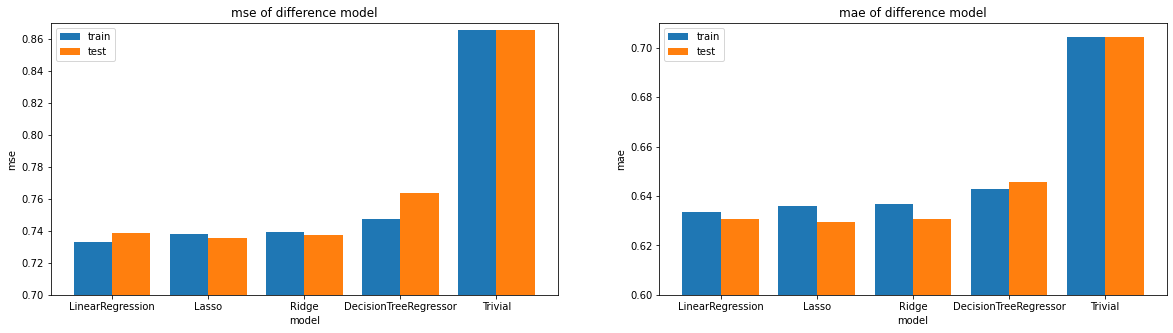

In [69]:
bar_width = 0.4
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.bar([x for x in range(5)], height=model_compare_result["train_mse"], label="train", width=bar_width)
plt.bar([x+bar_width for x in range(5)], height=model_compare_result["test_mse"], label="test", width=bar_width)
plt.xticks([x+bar_width/2 for x in range(5)], model_compare_result["model"])
plt.ylim(0.7,0.87) 
plt.xlabel("model")
plt.ylabel("mse")
plt.title("mse of difference model")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar([x for x in range(5)], height=model_compare_result["train_mae"], label="train", width=bar_width)
plt.bar([x+bar_width for x in range(5)], height=model_compare_result["test_mae"], label="test", width=bar_width)
plt.xticks([x+bar_width/2 for x in range(5)], model_compare_result["model"])
plt.ylim(0.6,0.71) 
plt.xlabel("model")
plt.ylabel("mae")
plt.title("mae of difference model")
plt.legend()

plt.show()

### feature selection

#### Wrapper Method - RFE

In [70]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()

model = Lasso(**grid_search_lasso.best_params_)
rfe_selector = RFE(estimator=model, n_features_to_select=30, step=100, verbose=0)
rfe_selector.fit(X, Y)
rfe_support = rfe_selector.get_support()
rfe_select_attributes = [t for i, t in enumerate(all_attribute_names+all_construct_attribute_names) if rfe_support[i]]
print(f"RFE select attributes: {rfe_select_attributes}")

RFE select attributes: ['num_hrefs', 'num_imgs', 'average_token_length', 'data_channel_is_entertainment', 'kw_min_min', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_avg_sharess', 'is_weekend', 'LDA_00', 'LDA_04', 'global_subjectivity', 'bus_n_tokens_content', 'bus_average_token_length', 'bus_num_keywords', 'socmed_n_unique_tokens', 'socmed_n_non_stop_words', 'socmed_num_hrefs', 'socmed_num_keywords', 'tech_n_tokens_content', 'world_num_imgs', 'world_average_token_length', 'socmed_LDA_00', 'lifestyle_global_subjectivity', 'socmed_global_subjectivity', 'world_global_rate_positive_words', 'monday_global_subjectivity']


#### Wrapper Method - SequentialFeatureSelector Forward

In [71]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()

model = Lasso(**grid_search_lasso.best_params_)
sfs_selector = SequentialFeatureSelector(estimator=model, scoring="neg_mean_squared_error", n_features_to_select=30, direction='forward', cv=2)
sfs_selector.fit_transform(X, Y)
sfs_support = sfs_selector.get_support()
sfs_select_attributes = [t for i, t in enumerate(all_attribute_names+all_construct_attribute_names) if sfs_support[i]]
print(f"SFS forward select attributes: {sfs_select_attributes}")

SFS forward select attributes: ['timedelta', 'num_hrefs', 'num_self_hrefs', 'data_channel_is_entertainment', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_avg_sharess', 'is_weekend', 'LDA_01', 'title_subjectivity', 'title_sentiment_polarity', 'bus_n_tokens_content', 'bus_n_unique_tokens', 'bus_average_token_length', 'tech_n_tokens_content', 'tech_num_videos', 'world_num_imgs', 'world_num_videos', 'entertainment_is_weekend', 'bus_is_weekend', 'entertainment_LDA_01', 'socmed_LDA_00', 'world_LDA_02', 'socmed_global_sentiment_polarity', 'monday_global_subjectivity', 'friday_rate_positive_words', 'weekend_rate_positive_words']


#### VIF 

In [72]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()

vif_attribute_names = all_attribute_names+all_construct_attribute_names
vif_select_num = 30
vif_select_attributes = []
vif_list = [variance_inflation_factor(X, i) for i in range(len(vif_attribute_names))]
index = np.argsort(vif_list)

for idx in index[:vif_select_num]:
    vif_select_attributes.append(vif_attribute_names[idx])
    print(f"select top {len(vif_select_attributes)} attribute:{vif_select_attributes[-1]}, vif:{vif_list[idx]}")

select top 1 attribute:lifestyle_num_videos, vif:1.1956067769204368
select top 2 attribute:tech_num_videos, vif:1.2581942978435665
select top 3 attribute:title_sentiment_polarity, vif:1.3402813599711345
select top 4 attribute:world_num_videos, vif:1.351188328452783
select top 5 attribute:abs_title_subjectivity, vif:1.4374762639987668
select top 6 attribute:kw_min_max, vif:1.4650531693823374
select top 7 attribute:socmed_num_videos, vif:1.5167094193153123
select top 8 attribute:bus_num_videos, vif:1.538790082668251
select top 9 attribute:bus_num_imgs, vif:1.8363476257100153
select top 10 attribute:min_positive_polarity, vif:2.0866525344435742
select top 11 attribute:timedelta, vif:2.3515451068977544
select top 12 attribute:title_subjectivity, vif:2.391664637691841
select top 13 attribute:abs_title_sentiment_polarity, vif:2.4312581428212354
select top 14 attribute:kw_min_avg, vif:2.473377779678602
select top 15 attribute:world_num_imgs, vif:2.7276028008496884
select top 16 attribute:life

Comparing the combined effects of different models and different feature selection methods

In [74]:
X = data[all_attribute_names+all_construct_attribute_names].copy()
Y = data["shares"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)
fs_result = pd.DataFrame(columns=['model', 'feature_select_method', "n_attributes", "mse", "mae"], index=[])
result_idx = 0
for model_class, best_params in [[LinearRegression, grid_search_lr.best_params_], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    for method_name, select_attributes in [["rfe", rfe_select_attributes], ["sfs", sfs_select_attributes], ["vif", vif_select_attributes]]:
        for i in range(30):
            model = model_class(**best_params)
            model.fit(X_train[select_attributes[:i+1]], Y_train)
            pred = model.predict(X_test[select_attributes[:i+1]])
            mse = mean_squared_error(Y_test, pred)
            mae = mean_absolute_error(Y_test, pred)
            fs_result.loc[result_idx] = [model_class.__name__, method_name, i+1, mse, mae]
            result_idx += 1
            print(f"{model_class.__name__} {method_name} {i+1} attributes, mse={mse}, mae={mae}")

LinearRegression rfe 1 attributes, mse=0.8444847001738476, mae=0.6933702695947567
LinearRegression rfe 2 attributes, mse=0.8413354851640307, mae=0.6920453378558218
LinearRegression rfe 3 attributes, mse=0.8375271185292783, mae=0.690393030484574
LinearRegression rfe 4 attributes, mse=0.8311340037702218, mae=0.6839056225955119
LinearRegression rfe 5 attributes, mse=0.8308993009234327, mae=0.6832759760465407
LinearRegression rfe 6 attributes, mse=0.8259060476780203, mae=0.6817229478332619
LinearRegression rfe 7 attributes, mse=0.8218450877744837, mae=0.6788676146688928
LinearRegression rfe 8 attributes, mse=0.8091764000174327, mae=0.6725849532105201
LinearRegression rfe 9 attributes, mse=0.7753101421771715, mae=0.6544658944685191
LinearRegression rfe 10 attributes, mse=0.7681726051210866, mae=0.6512126995371353
LinearRegression rfe 11 attributes, mse=0.76610035449673, mae=0.6502080724767217
LinearRegression rfe 12 attributes, mse=0.7584682830951482, mae=0.6451482692800093
LinearRegression

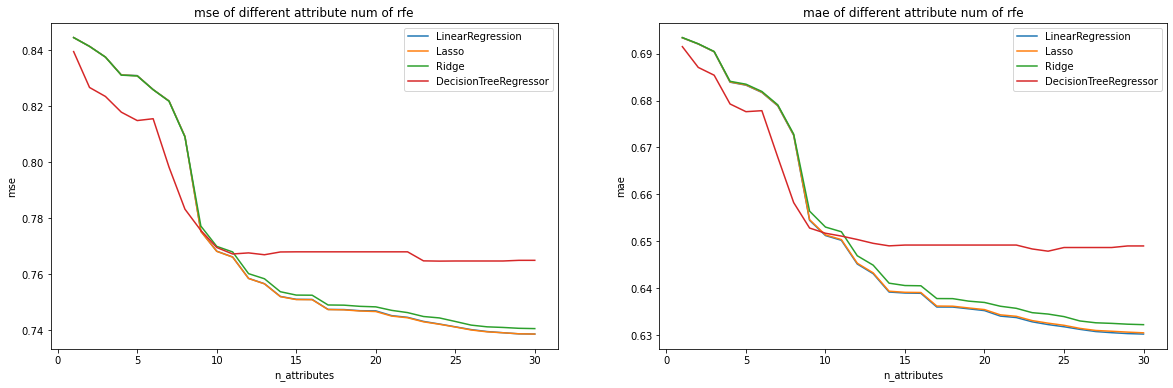

In [75]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'mse of different attribute num of rfe')
plt.legend()
plt.subplot(1, 2, 2)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'mae of different attribute num of rfe')
plt.legend()
plt.show()

In [76]:
fs_result[fs_result["n_attributes"].isin([1, 5, 15, 25, 30])][fs_result["feature_select_method"]=="rfe"]

,model,feature_select_method,n_attributes,mse,mae
0,LinearRegression,rfe,1,0.844485,0.693370
4,LinearRegression,rfe,5,0.830899,0.683276
14,LinearRegression,rfe,15,0.750986,0.638965
24,LinearRegression,rfe,25,0.741165,0.631776
29,LinearRegression,rfe,30,0.738579,0.630216
90,Lasso,rfe,1,0.844480,0.693382
94,Lasso,rfe,5,0.830843,0.683335
104,Lasso,rfe,15,0.750891,0.639118
114,Lasso,rfe,25,0.741087,0.632086
119,Lasso,rfe,30,0.738573,0.630482


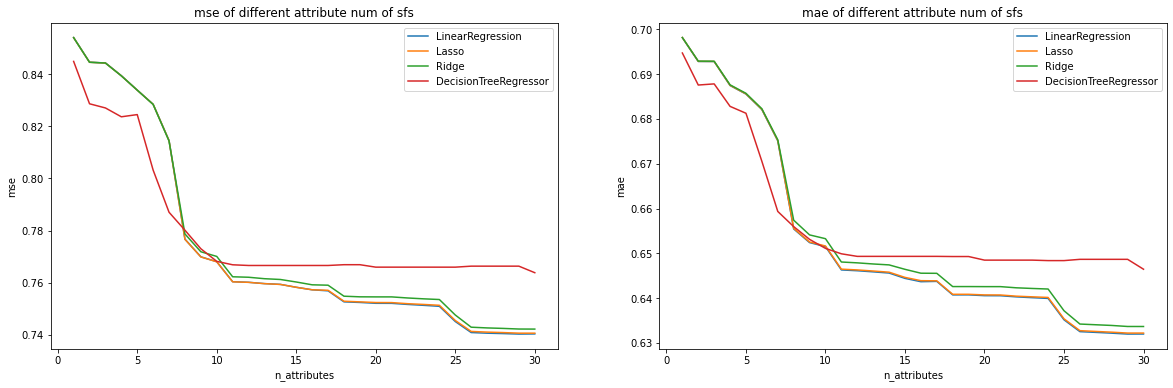

In [77]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'mse of different attribute num of sfs')
plt.legend()
plt.subplot(1, 2, 2)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'mae of different attribute num of sfs')
plt.legend()
plt.show()

In [79]:
fs_result[fs_result["n_attributes"].isin([1, 5, 15, 25, 30])][fs_result["feature_select_method"]=="sfs"]

,model,feature_select_method,n_attributes,mse,mae
30,LinearRegression,sfs,1,0.853989,0.698154
34,LinearRegression,sfs,5,0.833837,0.685558
44,LinearRegression,sfs,15,0.758253,0.644415
54,LinearRegression,sfs,25,0.745121,0.635171
59,LinearRegression,sfs,30,0.740367,0.631997
120,Lasso,sfs,1,0.853963,0.698170
124,Lasso,sfs,5,0.833823,0.685601
134,Lasso,sfs,15,0.758247,0.644638
144,Lasso,sfs,25,0.745525,0.635392
149,Lasso,sfs,30,0.740664,0.632210


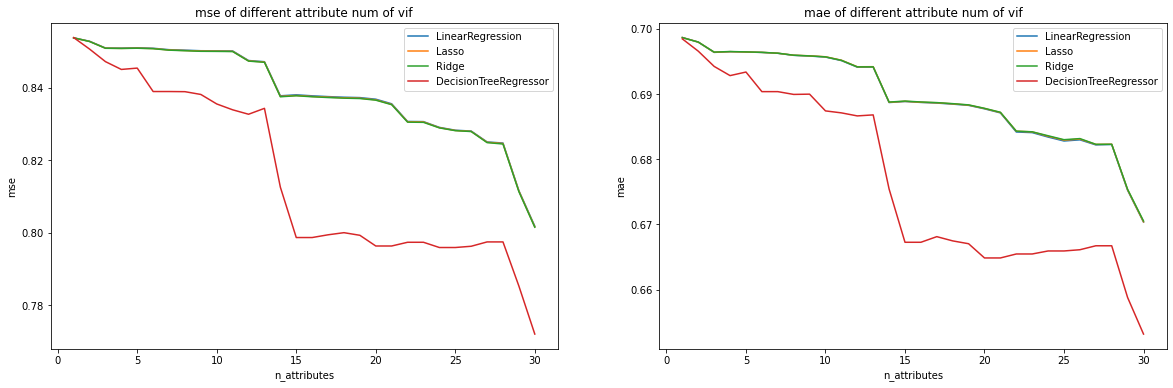

In [80]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'mse of different attribute num of vif')
plt.legend()
plt.subplot(1, 2, 2)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='LinearRegression')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Lasso')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='Ridge')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='DecisionTreeRegressor')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'mae of different attribute num of vif')
plt.legend()
plt.show()

In [81]:
fs_result[fs_result["n_attributes"].isin([1, 5, 15, 25, 30])][fs_result["feature_select_method"]=="vif"]

,model,feature_select_method,n_attributes,mse,mae
60,LinearRegression,vif,1,0.853853,0.698687
64,LinearRegression,vif,5,0.851110,0.696474
74,LinearRegression,vif,15,0.838115,0.688868
84,LinearRegression,vif,25,0.828337,0.682809
89,LinearRegression,vif,30,0.801829,0.670364
150,Lasso,vif,1,0.853837,0.698683
154,Lasso,vif,5,0.851002,0.696469
164,Lasso,vif,15,0.837926,0.688898
174,Lasso,vif,25,0.828261,0.682945
179,Lasso,vif,30,0.801654,0.670405


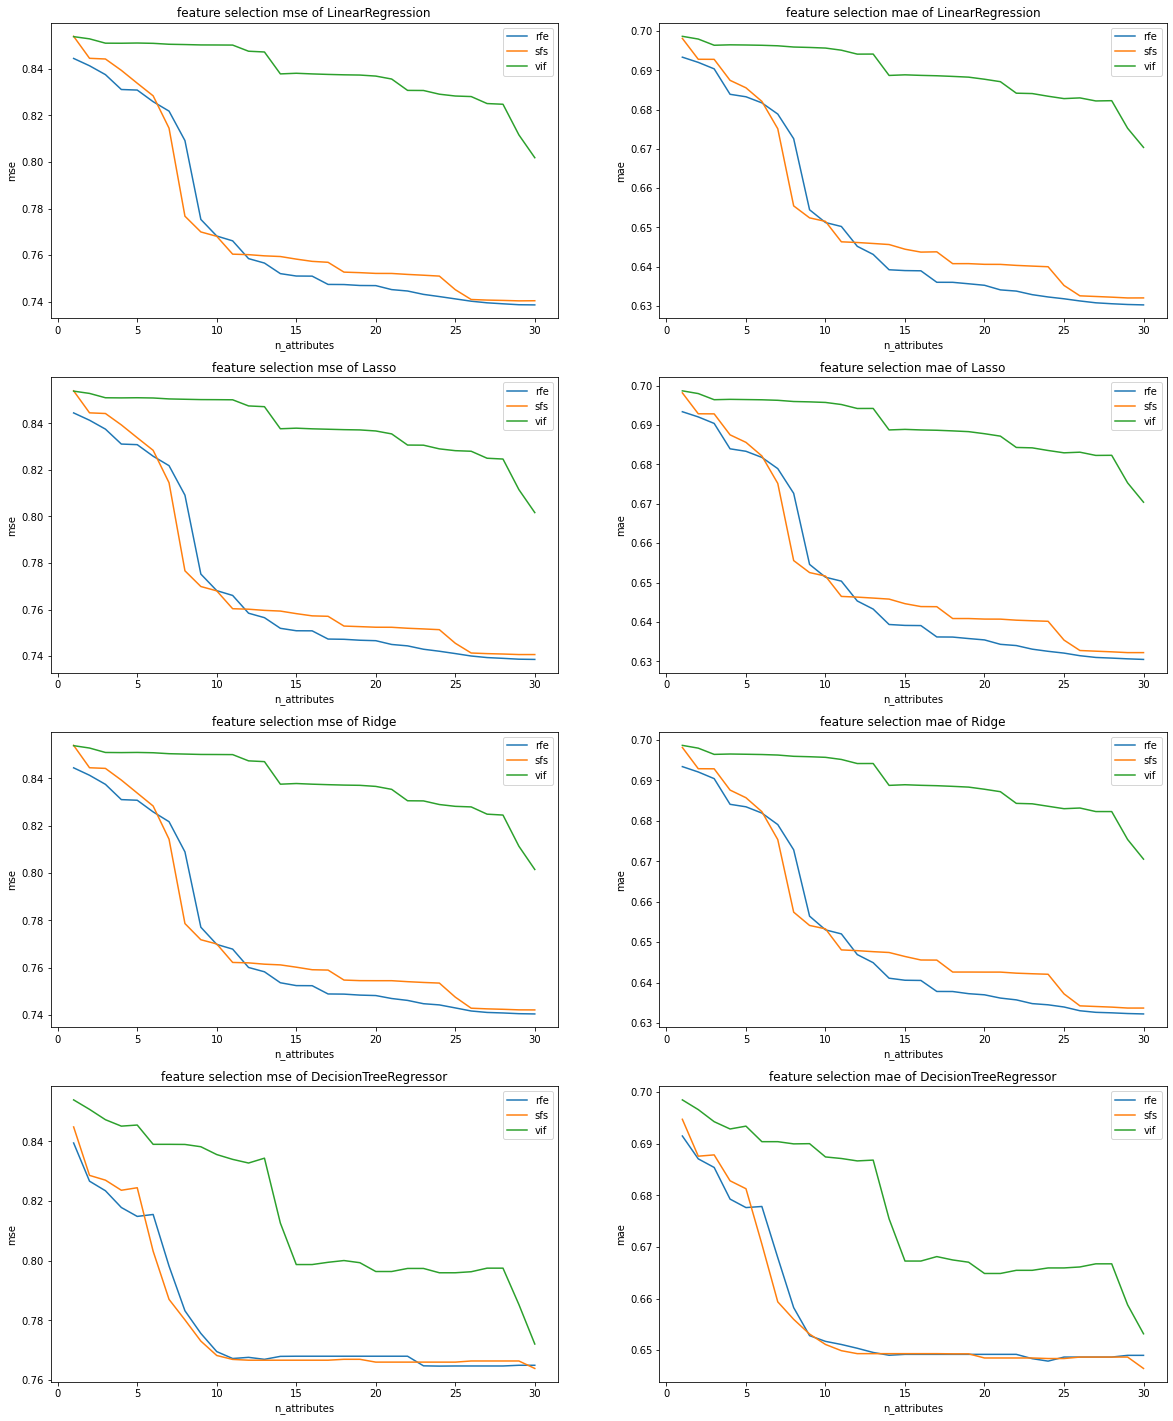

In [82]:
plt.figure(figsize=(20, 25))
plt.subplot(4, 2, 1)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='rfe')
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='sfs')
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'feature selection mse of LinearRegression')
plt.legend()
plt.subplot(4, 2, 2)
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='rfe')
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='sfs')
filter_result = fs_result[fs_result["model"]=="LinearRegression"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'feature selection mae of LinearRegression')
plt.legend()
plt.subplot(4, 2, 3)
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='rfe')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='sfs')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'feature selection mse of Lasso')
plt.legend()
plt.subplot(4, 2, 4)
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='rfe')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='sfs')
filter_result = fs_result[fs_result["model"]=="Lasso"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'feature selection mae of Lasso')
plt.legend()
plt.subplot(4, 2, 5)
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='rfe')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='sfs')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'feature selection mse of Ridge')
plt.legend()
plt.subplot(4, 2, 6)
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='rfe')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='sfs')
filter_result = fs_result[fs_result["model"]=="Ridge"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'feature selection mae of Ridge')
plt.legend()
plt.subplot(4, 2, 7)
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='rfe')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='sfs')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mse"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mse')
plt.title(f'feature selection mse of DecisionTreeRegressor')
plt.legend()
plt.subplot(4, 2, 8)
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="rfe"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='rfe')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="sfs"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='sfs')
filter_result = fs_result[fs_result["model"]=="DecisionTreeRegressor"][fs_result["feature_select_method"]=="vif"]
plt.plot(filter_result["n_attributes"], filter_result["mae"], label='vif')
plt.xlabel('n_attributes')
plt.ylabel('mae')
plt.title(f'feature selection mae of DecisionTreeRegressor')
plt.legend()
plt.show()

Combining the features extracted by the three methods

In [84]:
combine_select_attributes = list(set(rfe_select_attributes + sfs_select_attributes + vif_select_attributes))
print(f"Combined with rfe, sfs, vif feature selection, there are a total of {len(combine_select_attributes)} features,{combine_select_attributes}\n")

X = data[combine_select_attributes].copy()
Y = data["shares"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)

combine_attribute_result = pd.DataFrame(columns=['model', 'train_mse', "train_mae", "test_mse", "test_mae"], index=[])
result_idx = 0
for model_class, best_params in [[LinearRegression, {}], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train, Y_train)
    pred = model.predict(X_train)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    combine_attribute_result.loc[result_idx] = [model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"{model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

Combined with rfe, sfs, vif feature selection, there are a total of 64 features,['abs_title_subjectivity', 'num_imgs', 'bus_is_weekend', 'bus_n_tokens_content', 'world_average_token_length', 'entertainment_LDA_01', 'kw_min_max', 'lifestyle_global_subjectivity', 'bus_num_videos', 'weekend_rate_positive_words', 'bus_n_unique_tokens', 'world_num_videos', 'bus_num_self_hrefs', 'world_num_imgs', 'socmed_num_imgs', 'world_global_rate_positive_words', 'average_token_length', 'world_num_self_hrefs', 'lifestyle_num_videos', 'socmed_num_videos', 'abs_title_sentiment_polarity', 'socmed_LDA_00', 'LDA_04', 'world_LDA_02', 'self_reference_min_shares', 'global_subjectivity', 'is_weekend', 'bus_num_keywords', 'socmed_n_non_stop_words', 'num_self_hrefs', 'kw_max_avg', 'kw_min_min', 'bus_average_token_length', 'lifestyle_num_self_hrefs', 'tech_n_tokens_content', 'socmed_global_subjectivity', 'num_videos', 'title_sentiment_polarity', 'kw_max_max', 'max_negative_polarity', 'socmed_num_keywords', 'kw_min_a

In [85]:
combine_attribute_result

,model,train_mse,train_mae,test_mse,test_mae
0,LinearRegression,0.744381,0.637540,0.735260,0.628366
1,Lasso,0.744947,0.638531,0.735374,0.629032
2,Ridge,0.747066,0.640183,0.737340,0.630565
3,DecisionTreeRegressor,0.750177,0.644506,0.767796,0.648496


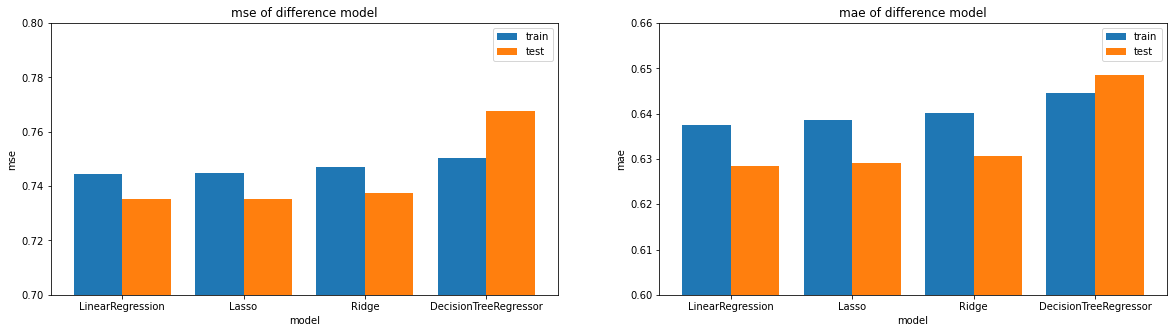

In [86]:
bar_width = 0.4
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.bar([x for x in range(4)], height=combine_attribute_result["train_mse"], label="train", width=bar_width)
plt.bar([x+bar_width for x in range(4)], height=combine_attribute_result["test_mse"], label="test", width=bar_width)
plt.xticks([x+bar_width/2 for x in range(4)], combine_attribute_result["model"])
plt.ylim(0.7,0.8)
plt.xlabel("model")
plt.ylabel("mse")
plt.title("mse of difference model")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar([x for x in range(4)], height=combine_attribute_result["train_mae"], label="train", width=bar_width)
plt.bar([x+bar_width for x in range(4)], height=combine_attribute_result["test_mae"], label="test", width=bar_width)
plt.xticks([x+bar_width/2 for x in range(4)], combine_attribute_result["model"])
plt.ylim(0.6,0.66)
plt.xlabel("model")
plt.ylabel("mae")
plt.title("mae of difference model")
plt.legend()

plt.show()

### missing data experiment

In [87]:
# preparing data
X = data[all_attribute_names].copy()
Y = data["shares"].copy()
# complete training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2022)
# Copy a piece of data, and change 10% of the data in some columns to nan, missing values
X_train_miss_value = X_train.copy()
X_test_miss_value = X_test.copy()
miss_value_attribute_names = [i for i in all_attribute_names if i in combine_select_attributes]
miss_value_attribute_names_idx = [i for i, j in enumerate(all_attribute_names) if j in combine_select_attributes]
for attribute in miss_value_attribute_names:
    for i in range(X_train_miss_value.shape[0]):
        if random.random() <= 0.3:
            X_train_miss_value[attribute].iloc[i] = pd.NA
    for i in range(X_test_miss_value.shape[0]):
        if random.random() <= 0.3:
            X_test_miss_value[attribute].iloc[i] = pd.NA     
# save results
miss_value_result = pd.DataFrame(columns=['fill_miss_method', 'model', 'train_mse', "train_mae", "test_mse", "test_mae"], index=[])
result_idx = 0

In [88]:
# no missing situation
for model_class, best_params in [[LinearRegression, grid_search_lr.best_params_], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train, Y_train)
    pred = model.predict(X_train)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    miss_value_result.loc[result_idx] = ["no-miss", model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"no miss value, {model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

no miss value, LinearRegression, train_mse=0.7519904188839733, train_mae=0.6427033675484812, test_mse=0.7440221736400491, test_mae=0.6345113685775697
no miss value, Lasso, train_mse=0.7523316953467506, train_mae=0.6428196929909842, test_mse=0.7436744396867099, test_mae=0.6345047173245251
no miss value, Ridge, train_mse=0.7539842284149748, train_mae=0.6441513191044107, test_mse=0.7450397412019323, test_mae=0.6357256103366744
no miss value, DecisionTreeRegressor, train_mse=0.7521528890284359, train_mae=0.6469437856784158, test_mse=0.7702055417387246, test_mae=0.6503766077388955


In [89]:
# fill-0
X_train_miss_value_copy = X_train_miss_value.copy()
X_test_miss_value_copy = X_test_miss_value.copy()
X_train_miss_value_copy.fillna(0, inplace=True)
X_test_miss_value_copy.fillna(0, inplace=True)
for model_class, best_params in [[LinearRegression, {}], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train_miss_value_copy, Y_train)
    pred = model.predict(X_train_miss_value_copy)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test_miss_value_copy)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    miss_value_result.loc[result_idx] = ["fill-0", model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"fill-0, {model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

fill-0, LinearRegression, train_mse=0.7735184399891181, train_mae=0.6535184782058833, test_mse=0.7637447351221769, test_mae=0.6444811235904803
fill-0, Lasso, train_mse=0.773734946832771, train_mae=0.6543873220277614, test_mse=0.7634940507815492, test_mae=0.6450912793034601
fill-0, Ridge, train_mse=0.7738458616935349, train_mae=0.6545443054468264, test_mse=0.7635106641762716, test_mae=0.6454895871339419
fill-0, DecisionTreeRegressor, train_mse=0.773301568931713, train_mae=0.6579708154433229, test_mse=0.7863227360953399, test_mae=0.6598426244249929


In [90]:
# fill-mean
X_train_miss_value_copy = X_train_miss_value.copy()
X_test_miss_value_copy = X_test_miss_value.copy()
A = pd.concat([X_train_miss_value_copy, X_test_miss_value_copy])
X_train_miss_value_copy.fillna(A.mean(), inplace=True)
X_test_miss_value_copy.fillna(A.mean(), inplace=True)
for model_class, best_params in [[LinearRegression, {}], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train_miss_value_copy, Y_train)
    pred = model.predict(X_train_miss_value_copy)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test_miss_value_copy)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    miss_value_result.loc[result_idx] = ["fill-mean", model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"fill-mean, {model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

fill-mean, LinearRegression, train_mse=0.7735210348431606, train_mae=0.6535271604104211, test_mse=0.763733837350483, test_mae=0.6444859114027639
fill-mean, Lasso, train_mse=0.7737370190790861, train_mae=0.6543775404118505, test_mse=0.7634882678771142, test_mae=0.6450774324712817
fill-mean, Ridge, train_mse=0.7738479086563805, train_mae=0.6545344537385549, test_mse=0.7635043304404241, test_mae=0.6454761825961027
fill-mean, DecisionTreeRegressor, train_mse=0.773301568931713, train_mae=0.6579708154433229, test_mse=0.7863227360953399, test_mae=0.6598426244249929


In [91]:
# fill-knn
X_train_miss_value_copy = X_train_miss_value.copy()
X_test_miss_value_copy = X_test_miss_value.copy()
X_train_miss_value_copy.fillna(np.nan, inplace=True)
X_test_miss_value_copy.fillna(np.nan, inplace=True)
imputer = KNNImputer(n_neighbors=2)
X_train_miss_value_copy = imputer.fit_transform(X_train_miss_value_copy)
imputer = KNNImputer(n_neighbors=2)
X_test_miss_value_copy = imputer.fit_transform(X_test_miss_value_copy)
for model_class, best_params in [[LinearRegression, {}], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train_miss_value_copy, Y_train)
    pred = model.predict(X_train_miss_value_copy)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test_miss_value_copy)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    miss_value_result.loc[result_idx] = ["fill-knn", model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"fill-knn, {model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

fill-knn, LinearRegression, train_mse=0.7696348458542106, train_mae=0.6507684182168457, test_mse=0.7593833021739886, test_mae=0.6420487149296672
fill-knn, Lasso, train_mse=0.7698827837477938, train_mae=0.650191398827394, test_mse=0.7591816606857951, test_mae=0.641313210494375
fill-knn, Ridge, train_mse=0.7700588712632699, train_mae=0.6505300549404927, test_mse=0.7591225472341127, test_mae=0.6417274810142395
fill-knn, DecisionTreeRegressor, train_mse=0.7637681184295988, train_mae=0.6528835014452147, test_mse=0.7805366660196796, test_mae=0.6550968467783352


In [92]:
# predict miss value
X_train_miss_value_copy = X_train_miss_value.copy()
X_test_miss_value_copy = X_test_miss_value.copy()
X_train_miss_value_copy_2 = X_train_miss_value.copy()
X_test_miss_value_copy_2 = X_test_miss_value.copy()

for attribute in miss_value_attribute_names:
    index_train_notna = X_train_miss_value_copy_2[attribute].notna()
    index_train_na = X_train_miss_value_copy_2[attribute].isna()
    index_test_notna = X_test_miss_value_copy_2[attribute].notna()
    index_test_na = X_test_miss_value_copy_2[attribute].isna()    
    X_notna = pd.concat([X_train_miss_value_copy_2.loc[:, X_train_miss_value_copy_2.columns != attribute][index_train_notna], X_test_miss_value_copy_2.loc[:, X_test_miss_value_copy_2.columns != attribute][index_test_notna]])
    Y_notna = pd.concat([X_train_miss_value_copy_2[attribute][index_train_notna], X_test_miss_value_copy_2[attribute][index_test_notna]])
    X_notna_mean = X_notna.mean()
    X_notna = X_notna.copy().fillna(X_notna_mean)
    model = LinearRegression()
    model.fit(X_notna, Y_notna)
    X_na_train = X_train_miss_value_copy_2.loc[:, X_train_miss_value_copy_2.columns != attribute][index_train_na].copy()
    X_na_train = X_na_train.fillna(X_notna_mean)
    X_na_test = X_test_miss_value_copy_2.loc[:, X_test_miss_value_copy_2.columns != attribute][index_test_na].copy()
    X_na_test = X_na_test.fillna(X_notna_mean)    
    X_train_miss_value_copy[attribute][index_train_na] = model.predict(X_na_train)
    X_test_miss_value_copy[attribute][index_test_na] = model.predict(X_na_test)
    
for model_class, best_params in [[LinearRegression, {}], [Lasso, grid_search_lasso.best_params_], [Ridge, grid_search_ridge.best_params_], [DecisionTreeRegressor, grid_search_tree.best_params_]]:
    model = model_class(**best_params)
    model.fit(X_train_miss_value_copy, Y_train)
    pred = model.predict(X_train_miss_value_copy)
    mse_train = mean_squared_error(Y_train, pred)
    mae_train = mean_absolute_error(Y_train, pred)
    pred = model.predict(X_test_miss_value_copy)
    mse_test = mean_squared_error(Y_test, pred)
    mae_test = mean_absolute_error(Y_test, pred)
    miss_value_result.loc[result_idx] = ["fill-predict", model_class.__name__, mse_train, mae_train, mse_test, mae_test]
    result_idx += 1
    print(f"fill-predict, {model_class.__name__}, train_mse={mse_train}, train_mae={mae_train}, test_mse={mse_test}, test_mae={mae_test}")

fill-predict, LinearRegression, train_mse=0.764154574475591, train_mae=0.6482761733807408, test_mse=0.7542694087094773, test_mae=0.6391610931250681
fill-predict, Lasso, train_mse=0.7643650868586528, train_mae=0.64900794038882, test_mse=0.7540470339327318, test_mae=0.6400075787837709
fill-predict, Ridge, train_mse=0.7654202155189914, train_mae=0.6497239480504408, test_mse=0.7551039497101589, test_mae=0.6409668442198019
fill-predict, DecisionTreeRegressor, train_mse=0.756137406649634, train_mae=0.6476586543570946, test_mse=0.775145202730103, test_mae=0.6535134675877198


In [93]:
miss_value_result

,fill_miss_method,model,train_mse,train_mae,test_mse,test_mae
0,no-miss,LinearRegression,0.751990,0.642703,0.744022,0.634511
1,no-miss,Lasso,0.752332,0.642820,0.743674,0.634505
2,no-miss,Ridge,0.753984,0.644151,0.745040,0.635726
3,no-miss,DecisionTreeRegressor,0.752153,0.646944,0.770206,0.650377
4,fill-0,LinearRegression,0.773518,0.653518,0.763745,0.644481
5,fill-0,Lasso,0.773735,0.654387,0.763494,0.645091
6,fill-0,Ridge,0.773846,0.654544,0.763511,0.645490
7,fill-0,DecisionTreeRegressor,0.773302,0.657971,0.786323,0.659843
8,fill-mean,LinearRegression,0.773521,0.653527,0.763734,0.644486
9,fill-mean,Lasso,0.773737,0.654378,0.763488,0.645077


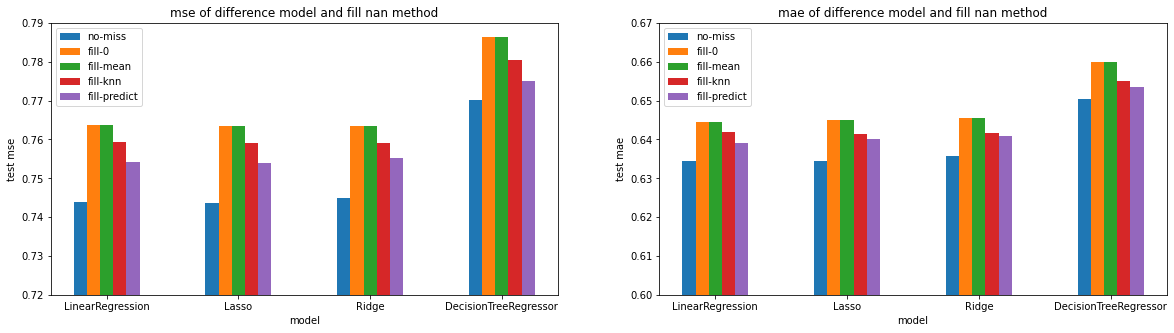

In [94]:
bar_width = 0.1
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.bar([x for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="no-miss"]["test_mse"], label="no-miss", width=bar_width)
plt.bar([x+bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-0"]["test_mse"], label="fill-0", width=bar_width)
plt.bar([x+2*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-mean"]["test_mse"], label="fill-mean", width=bar_width)
plt.bar([x+3*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-knn"]["test_mse"], label="fill-knn", width=bar_width)
plt.bar([x+4*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-predict"]["test_mse"], label="fill-predict", width=bar_width)
plt.xticks([x+4*bar_width/2 for x in range(4)], miss_value_result[miss_value_result["fill_miss_method"]=="no-miss"]["model"])
plt.ylim(0.72,0.79)
plt.xlabel("model")
plt.ylabel("test mse")
plt.title("mse of difference model and fill nan method")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar([x for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="no-miss"]["test_mae"], label="no-miss", width=bar_width)
plt.bar([x+bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-0"]["test_mae"], label="fill-0", width=bar_width)
plt.bar([x+2*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-mean"]["test_mae"], label="fill-mean", width=bar_width)
plt.bar([x+3*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-knn"]["test_mae"], label="fill-knn", width=bar_width)
plt.bar([x+4*bar_width for x in range(4)], height=miss_value_result[miss_value_result["fill_miss_method"]=="fill-predict"]["test_mae"], label="fill-predict", width=bar_width)
plt.xticks([x+4*bar_width/2 for x in range(4)], miss_value_result[miss_value_result["fill_miss_method"]=="no-miss"]["model"])
plt.ylim(0.6,0.67)
plt.xlabel("model")
plt.ylabel("test mae")
plt.title("mae of difference model and fill nan method")
plt.legend()

plt.show()

### SSL

### Pseudo-Labelling (CoReg)

In [95]:
X = data[all_attribute_names].copy()
Y = data["shares"].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=2022)
X_train_labeled = X_train.iloc[:X_train.shape[0]//2, :]
Y_train_labeled = Y_train.iloc[:X_train.shape[0]//2]
X_train_unlabeled = X_train.iloc[X_train.shape[0]//2:, :]
model = LinearRegression()
model.fit(X_train_labeled, Y_train_labeled)
pred = model.predict(X_test)
mse_test = mean_squared_error(Y_test, pred)
mae_test = mean_absolute_error(Y_test, pred)
print(f"Train with labeled data only, test_mse={mse_test}, test_mae={mae_test}")

Train with labeled data only, test_mse=0.7466439536622556, test_mae=0.6366081292115173


In [99]:
X_labeled_1 = X_train_labeled.copy().values
Y_labeled_1 = Y_train_labeled.copy().values
X_labeled_2 = X_train_labeled.copy().values
Y_labeled_2 = Y_train_labeled.copy().values
X_unlabeled = X_train_unlabeled.copy().values
X_train_labeled_values = X_train_labeled.copy().values
Y_train_labeled_values = Y_train_labeled.copy().values

knn_params_1 = {"n_neighbors": 3, "p": 1}
knn_params_2 = {"n_neighbors": 3, "p": 2}
sample_num = 100
repeat_time = 100
added_idxs = []
pseudo_labeling_result = pd.DataFrame(columns=['add_data_num', 'test_mse', "test_mae"], index=[])
result_idx = 0

knn_find_neighbors_1 = KNeighborsRegressor(**knn_params_1)
knn_find_neighbors_2 = KNeighborsRegressor(**knn_params_2)
knn_find_neighbors_1.fit(X_train_labeled_values, Y_train_labeled_values)
knn_find_neighbors_2.fit(X_train_labeled_values, Y_train_labeled_values)

for t in range(1, repeat_time+1):
    knn1 = KNeighborsRegressor(**knn_params_1)
    knn2 = KNeighborsRegressor(**knn_params_2)
    knn1.fit(X_labeled_1, Y_labeled_1)
    knn2.fit(X_labeled_2, Y_labeled_2)
    sample_idxs = [i for i in range(X_unlabeled.shape[0]) if i not in added_idxs]
    random.shuffle(sample_idxs)
    sample_idxs = sample_idxs[:sample_num]

    for knn, knn_params, X_labeled, Y_labeled in [[knn1, knn_params_1, X_labeled_1, Y_labeled_1], [knn2, knn_params_2, X_labeled_2, Y_labeled_2]]:
        best_scores = -10000
        best_X_labeled_add = None
        best_Y_labeled_add = None
        best_idx = None
        for idx in sample_idxs:
            if knn is knn1:
                neighbors_idx_list = knn_find_neighbors_1.kneighbors(X=X_unlabeled[idx:idx+1, :], n_neighbors=5, return_distance=False)[0]
            else:
                neighbors_idx_list = knn_find_neighbors_2.kneighbors(X=X_unlabeled[idx:idx+1, :], n_neighbors=5, return_distance=False)[0]
                    
            # predict data of idx
            y_pred_idx = knn.predict(X_unlabeled[idx:idx+1, :])
            # fit evaluate model
            knn_eval = KNeighborsRegressor(**knn_params)
            X_labeled_add = np.vstack([X_labeled, X_unlabeled[idx:idx+1, :]])
            Y_labeled_add = np.hstack([Y_labeled, y_pred_idx])
            knn_eval.fit(X_labeled_add, Y_labeled_add)
            # evaluate
            scores_1 = 0
            scores_2 = 0
            for neighbors_idx in neighbors_idx_list:
                scores_1 += ((knn.predict(X_train_labeled_values[neighbors_idx:neighbors_idx+1, :]) - Y_train_labeled_values[neighbors_idx]) ** 2 -
                           (knn_eval.predict(X_train_labeled_values[neighbors_idx:neighbors_idx+1, :]) - Y_train_labeled_values[neighbors_idx]) ** 2)
                scores_2 += (abs(knn.predict(X_train_labeled_values[neighbors_idx:neighbors_idx+1, :]) - Y_train_labeled_values[neighbors_idx]) -
                           abs(knn_eval.predict(X_train_labeled_values[neighbors_idx:neighbors_idx+1, :]) - Y_train_labeled_values[neighbors_idx]))
            
            if scores_1 > 0 and scores_2 > 0 and best_scores < (scores_1+scores_2):
                best_scores = (scores_1+scores_2)
                best_X_labeled_add = X_labeled_add
                best_Y_labeled_add = Y_labeled_add
                best_idx = idx
        if best_scores > 0:
            if X_labeled is X_labeled_1:
                X_labeled_1 = best_X_labeled_add
                Y_labeled_1 = best_Y_labeled_add
            else:
                X_labeled_2 = best_X_labeled_add
                Y_labeled_2 = best_Y_labeled_add
            sample_idxs.remove(best_idx)
            added_idxs.append(best_idx)

            lr_model1 = LinearRegression()
            lr_model2 = LinearRegression()
            lr_model1.fit(X_labeled_1, Y_labeled_1)
            lr_model2.fit(X_labeled_2, Y_labeled_2)
            pred_1 = lr_model1.predict(X_test)
            pred_2 = lr_model2.predict(X_test)
            pred = (pred_1 + pred_2) / 2
            mse_test = mean_squared_error(Y_test, pred)
            mae_test = mean_absolute_error(Y_test, pred)
            print(f"Coreg add {len(added_idxs)} samples, test_mse={mse_test}, test_mae={mae_test}")
            pseudo_labeling_result.loc[result_idx] = [len(added_idxs), mse_test, mae_test]
            result_idx += 1

Coreg add 1 samples, test_mse=0.7466449407215388, test_mae=0.6366036714877362
Coreg add 2 samples, test_mse=0.7466405143369366, test_mae=0.6366248674527072
Coreg add 3 samples, test_mse=0.7466450971791624, test_mae=0.6366209472143329
Coreg add 4 samples, test_mse=0.7466446672218403, test_mae=0.6366225117769176
Coreg add 5 samples, test_mse=0.7466471304928495, test_mae=0.6366153838350395
Coreg add 6 samples, test_mse=0.7466392881757802, test_mae=0.6366035606321541
Coreg add 7 samples, test_mse=0.7466377632910763, test_mae=0.6365923732285211
Coreg add 8 samples, test_mse=0.7466374747349739, test_mae=0.636588579562883
Coreg add 9 samples, test_mse=0.746637691346293, test_mae=0.6365979543451634
Coreg add 10 samples, test_mse=0.7466321062505199, test_mae=0.6365857984479942
Coreg add 11 samples, test_mse=0.7466384980772867, test_mae=0.6366050845743891
Coreg add 12 samples, test_mse=0.7466196528901873, test_mae=0.6365792369915105
Coreg add 13 samples, test_mse=0.7466219546017285, test_mae=0.6

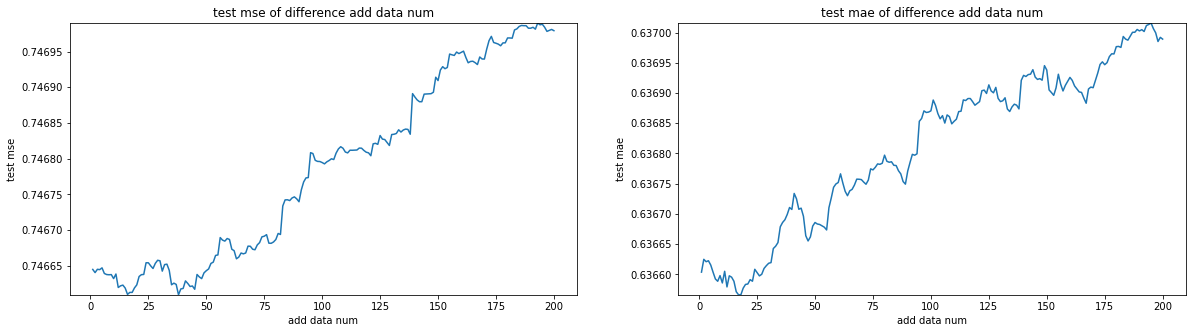

In [100]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(pseudo_labeling_result["add_data_num"], pseudo_labeling_result["test_mse"])
plt.ylim(pseudo_labeling_result["test_mse"].min(), pseudo_labeling_result["test_mse"].max())
plt.xlabel("add data num")
plt.ylabel("test mse")
plt.title("test mse of difference add data num")
plt.subplot(1, 2, 2)
plt.plot(pseudo_labeling_result["add_data_num"], pseudo_labeling_result["test_mae"])
plt.ylim(pseudo_labeling_result["test_mae"].min(), pseudo_labeling_result["test_mae"].max())
plt.xlabel("add data num")
plt.ylabel("test mae")
plt.title("test mae of difference add data num")
plt.show()

In [101]:
# SSL chart
pseudo_labeling_result[pseudo_labeling_result["add_data_num"].isin(list(range(0, 200, 20)))]

,add_data_num,test_mse,test_mae
19,20.0,0.746623,0.636583
39,40.0,0.746618,0.636707
59,60.0,0.746687,0.636752
79,80.0,0.746687,0.636797
99,100.0,0.746795,0.636870
119,120.0,0.746808,0.636883
139,140.0,0.746886,0.636929
159,160.0,0.746949,0.636926
179,180.0,0.746969,0.636977


### transfer learning

The original training target is the regression task (forwarding amount), and the target to be migrated is the channel classification (channel) of the sample

In [114]:
all_attribute_names_TL = [f for f in all_attribute_names if not f.startswith("data_channel_is")] 
channel_attribute_names_TL = [f for f in all_attribute_names if f.startswith("data_channel_is")]
X_TL = data[all_attribute_names_TL].copy().values
Y_shares = data["shares"].copy().values
Y_channel = data[channel_attribute_names_TL].copy().values
Y_channel = np.where(Y_channel == np.amax(Y_channel, axis=1, keepdims=True), 1, 0)
X_train_shares, X_test_shares, Y_train_shares, Y_test_shares = train_test_split(X_TL, Y_shares, test_size=0.4, random_state=2022)
X_train_channel, X_test_channel, Y_train_channel, Y_test_channel = train_test_split(X_TL, Y_channel, test_size=0.4, random_state=2022)
model_hidden_size_list = [100, 100, 50, 50]
model_activation = "tanh"

In [115]:
# Train the neural network from scratch to predict forwarding volume
model_share = keras.models.Sequential()
for hidden_size in model_hidden_size_list:
    model_share.add(keras.layers.Dense(hidden_size, activation=model_activation))
model_share.add(keras.layers.Dense(1))
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)]
model_share.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
train_history_shares = model_share.fit(X_train_shares, Y_train_shares, validation_data=(X_test_shares, Y_test_shares), batch_size=64, epochs=30, callbacks=callbacks)
share_predict_best_epoch = np.argmin(train_history_shares.history["val_mse"]) + 1
print(f" when epoch is {share_predict_best_epoch}, the best value of mse is :{train_history_shares.history['val_mse'][share_predict_best_epoch-1]}, mae is :{train_history_shares.history['val_mae'][share_predict_best_epoch-1]}")

Epoch 1/30
372/372 [==============================] - 1s 2ms/step - loss: 0.7860 - mse: 0.7860 - mae: 0.6612 - val_loss: 0.7514 - val_mse: 0.7514 - val_mae: 0.6375 - lr: 0.0010
Epoch 2/30
372/372 [==============================] - 0s 1ms/step - loss: 0.7573 - mse: 0.7573 - mae: 0.6471 - val_loss: 0.7588 - val_mse: 0.7588 - val_mae: 0.6365 - lr: 0.0010
Epoch 3/30
372/372 [==============================] - 0s 1ms/step - loss: 0.7453 - mse: 0.7453 - mae: 0.6424 - val_loss: 0.7472 - val_mse: 0.7472 - val_mae: 0.6297 - lr: 0.0010
Epoch 4/30
372/372 [==============================] - 0s 1ms/step - loss: 0.7334 - mse: 0.7334 - mae: 0.6366 - val_loss: 0.7592 - val_mse: 0.7592 - val_mae: 0.6467 - lr: 0.0010
Epoch 5/30
372/372 [==============================] - 0s 1ms/step - loss: 0.7231 - mse: 0.7231 - mae: 0.6329 - val_loss: 0.7577 - val_mse: 0.7577 - val_mae: 0.6433 - lr: 0.0010
Epoch 6/30
372/372 [==============================] - 0s 1ms/step - loss: 0.7137 - mse: 0.7137 - mae: 0.6278 - val_

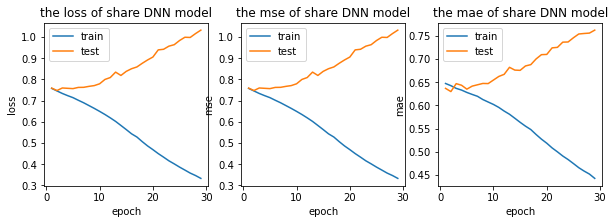

In [116]:
epochs = [i for i in range(len(train_history_shares.history["loss"]))]
plt.figure(figsize=(10, 3)) 
plt.subplot(1, 3, 1)
plt.plot(epochs[1:], train_history_shares.history["loss"][1:], label='train')
plt.plot(epochs[1:], train_history_shares.history["val_loss"][1:], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'the loss of share DNN model')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(epochs[1:], train_history_shares.history["mse"][1:], label='train')
plt.plot(epochs[1:], train_history_shares.history["val_mse"][1:], label='test')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.title(f'the mse of share DNN model')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(epochs[1:], train_history_shares.history["mae"][1:], label='train')
plt.plot(epochs[1:], train_history_shares.history["val_mae"][1:], label='test')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.title(f'the mae of share DNN model')
plt.legend()
plt.show()

In [117]:
# Train the neural network from scratch to predict the channel
model_channel = keras.models.Sequential()
for hidden_size in model_hidden_size_list:
    model_channel.add(keras.layers.Dense(hidden_size, activation=model_activation))
model_channel.add(keras.layers.Dense(len(channel_attribute_names_TL), activation="softmax"))
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)]
model_channel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
train_history_channel = model_channel.fit(X_train_channel, Y_train_channel, validation_data=(X_test_channel, Y_test_channel), batch_size=64, epochs=30, callbacks=callbacks)
channel_predict_best_epoch = np.argmax(train_history_channel.history["val_acc"]) + 1
print(f"when the epoch is {channel_predict_best_epoch}, tthe best value of acc is:{train_history_channel.history['val_acc'][channel_predict_best_epoch-1]}")

Epoch 1/30
372/372 [==============================] - 1s 2ms/step - loss: 0.6854 - acc: 0.7547 - val_loss: 0.6026 - val_acc: 0.7866 - lr: 0.0010
Epoch 2/30
372/372 [==============================] - 0s 1ms/step - loss: 0.5649 - acc: 0.7946 - val_loss: 0.5581 - val_acc: 0.8037 - lr: 0.0010
Epoch 3/30
372/372 [==============================] - 0s 1ms/step - loss: 0.5245 - acc: 0.8052 - val_loss: 0.5377 - val_acc: 0.8045 - lr: 0.0010
Epoch 4/30
372/372 [==============================] - 0s 1ms/step - loss: 0.4948 - acc: 0.8159 - val_loss: 0.5275 - val_acc: 0.8090 - lr: 0.0010
Epoch 5/30
372/372 [==============================] - 0s 1ms/step - loss: 0.4738 - acc: 0.8245 - val_loss: 0.5101 - val_acc: 0.8155 - lr: 0.0010
Epoch 6/30
372/372 [==============================] - 0s 1ms/step - loss: 0.4546 - acc: 0.8286 - val_loss: 0.5121 - val_acc: 0.8096 - lr: 0.0010
Epoch 7/30
372/372 [==============================] - 0s 1ms/step - loss: 0.4369 - acc: 0.8342 - val_loss: 0.5089 - val_acc: 0.811

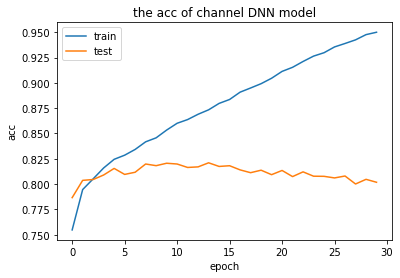

In [118]:
epochs = [i for i in range(len(train_history_channel.history["loss"]))]
plt.figure()
plt.plot(epochs, train_history_channel.history["acc"], label='train')
plt.plot(epochs, train_history_channel.history["val_acc"], label='test')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title(f'the acc of channel DNN model')
plt.legend()
plt.show()

TL, first train a regression model on the share, then freeze the layers of the model except the last two layers, and change the last layer to the classification layer, and migrate to the channel classification task

In [122]:
model_share = keras.models.Sequential()
for hidden_size in model_hidden_size_list:
    model_share.add(keras.layers.Dense(hidden_size, activation=model_activation))
model_share.add(keras.layers.Dense(1))
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)]
model_share.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
model_share.fit(X_train_shares, Y_train_shares, validation_data=(X_test_shares, Y_test_shares), batch_size=64, epochs=share_predict_best_epoch, callbacks=callbacks, verbose=False)

model_clone = keras.models.clone_model(model_share)
model_clone.set_weights(model_share.get_weights())
model_channel_TL = keras.models.Sequential(model_clone.layers[:-2]) 
model_channel_TL.add(keras.layers.Dense(model_hidden_size_list[-1], activation=model_activation))
model_channel_TL.add(keras.layers.Dense(len(channel_attribute_names_TL), activation="softmax"))


for layer in model_channel_TL.layers[:-2]:
    layer.trainable = False
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)]
model_channel_TL.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
train_history_channel_tl = model_channel_TL.fit(X_train_channel, Y_train_channel, validation_data=(X_test_channel, Y_test_channel), batch_size=64, epochs=30, callbacks=callbacks, verbose=False)
channel_predict_best_epoch_tl = np.argmax(train_history_channel_tl.history["val_acc"]) + 1
print(f"TL: When the epoch is {channel_predict_best_epoch_tl}, the best value of acc is:{train_history_channel_tl.history['val_acc'][channel_predict_best_epoch_tl-1]}")


TL: When the epoch is 29, the best value of acc is:0.7592382431030273


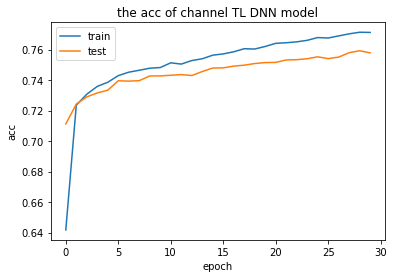

In [123]:
epochs = [i for i in range(len(train_history_channel_tl.history["loss"]))]
plt.figure()
plt.plot(epochs, train_history_channel_tl.history["acc"], label='train')
plt.plot(epochs, train_history_channel_tl.history["val_acc"], label='test')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title(f'the acc of channel TL DNN model')
plt.legend()
plt.show()

### Data Dimensionality Reduction

Use channel data to visualize and measure the effect of dimensionality reduction. Because of memory problems, only 10,000 samples are sampled for testing.

In [124]:
all_attribute_names_not_channel = [f for f in all_attribute_names if not f.startswith("data_channel_is")]
all_attribute_names_channel = [f for f in all_attribute_names if f.startswith("data_channel_is")]
data_samples = data.sample(10000)
X = data_samples[all_attribute_names_not_channel].copy().values
Y = data_samples["shares"].copy().values
Y_channel = data_samples[all_attribute_names_channel].copy().values
Y_channel = np.argmax(Y_channel, 1)

In [125]:
# Data Dimensionality Reduction
model = PCA(n_components=2)
X_pca = model.fit_transform(X)
model = KernelPCA(n_components=2, kernel="rbf")
X_pca_kernel = model.fit_transform(X)
model = Isomap(n_components=2)
X_isomap = model.fit_transform(X)
model = TSNE(n_components=2)
X_tsne = model.fit_transform(X)

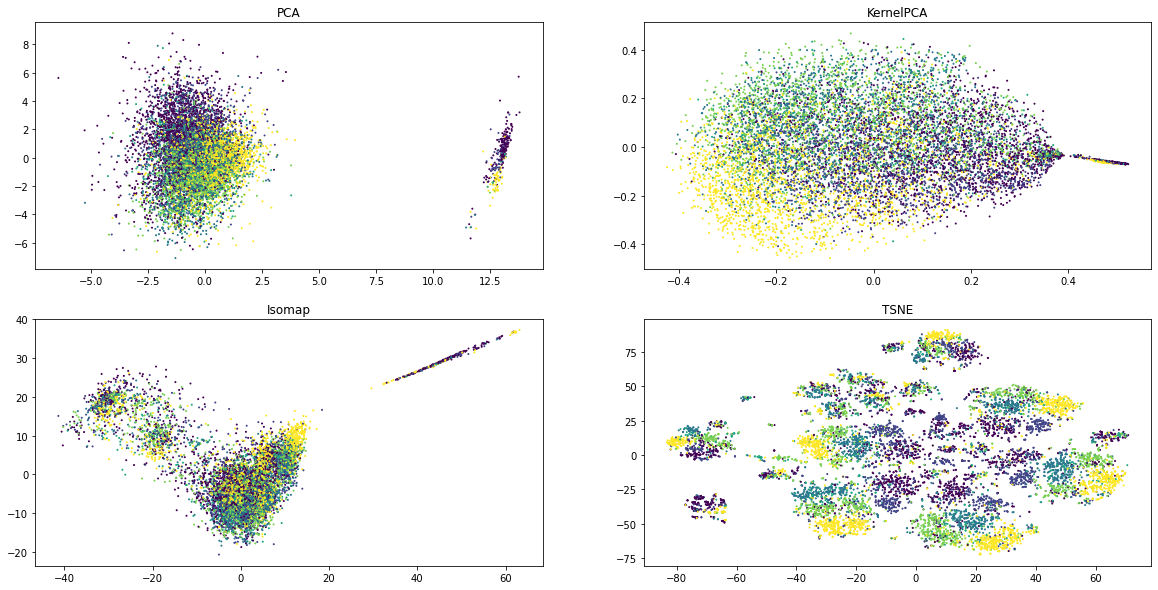

In [126]:
# plot
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_channel, s=1)
plt.title("PCA")
plt.subplot(2, 2, 2)
plt.scatter(X_pca_kernel[:, 0], X_pca_kernel[:, 1], c=Y_channel, s=1)
plt.title("KernelPCA")
plt.subplot(2, 2, 3)
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=Y_channel, s=1)
plt.title("Isomap")
plt.subplot(2, 2, 4)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_channel, s=1)
plt.title("TSNE")
plt.show()

In [127]:
dimension_reduce_result = pd.DataFrame(columns=['model', "test_mse", "test_mae"], index=[])
result_idx = 0
for model_name, cur_X in [["origin", X], ["PCA", X_pca], ["KernelPCA", X_pca_kernel], ["Isomap", X_isomap], ["TSNE", X_tsne]]:
    X_train, X_test, Y_train, Y_test = train_test_split(cur_X, Y, test_size=0.2, random_state=2022)
    model = DecisionTreeRegressor(min_samples_leaf=100)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, pred)
    mae = mean_absolute_error(Y_test, pred)
    dimension_reduce_result.loc[result_idx] = [model_name, mse, mae]
    result_idx += 1

In [128]:
dimension_reduce_result

,model,test_mse,test_mae
0,origin,0.803859,0.667640
1,PCA,0.850070,0.697143
2,KernelPCA,0.828681,0.682705
3,Isomap,0.857146,0.697279
4,TSNE,0.828265,0.685858


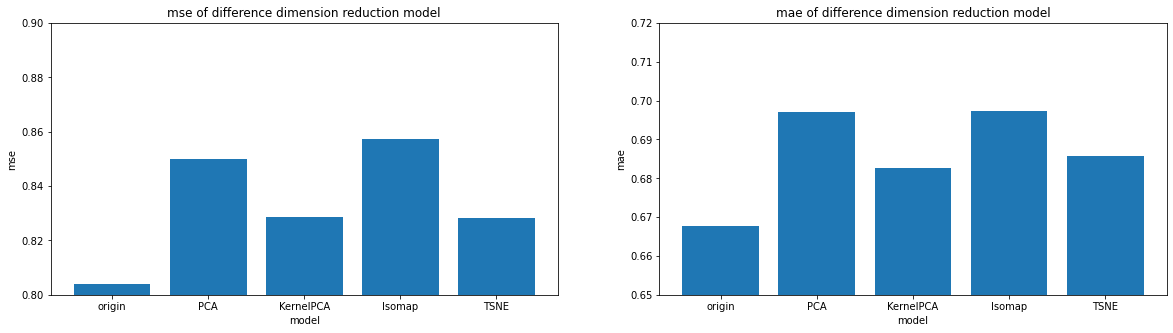

In [129]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.bar(dimension_reduce_result["model"], height=dimension_reduce_result["test_mse"])
plt.ylim(0.80, 0.9) 
plt.xlabel("model")
plt.ylabel("mse")
plt.title("mse of difference dimension reduction model")
plt.subplot(1, 2, 2)
plt.bar(dimension_reduce_result["model"], height=dimension_reduce_result["test_mae"])
plt.ylim(0.65, 0.72) 
plt.xlabel("model")
plt.ylabel("mae")
plt.title("mae of difference dimension reduction model")
plt.show()